### Библиотеки

In [406]:
import logging

logger = logging.getLogger(__name__)
import sys

c_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(c_handler)
logging.basicConfig(level=logging.INFO, force=True)

import random
import warnings
from datetime import datetime
from typing import Any

import numpy as np
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import torch
import torch.nn as nn
from chronos import BaseChronosPipeline
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from torch.nn import Module
from tqdm.notebook import tqdm

import tsururu.dataset
from tsururu.model_training.trainer import DLTrainer, MLTrainer
from tsururu.model_training.validator import KFoldCrossValidator, HoldOutValidator
from tsururu.models.boost import CatBoost, CatBoostRegressor
from tsururu.strategies import MIMOStrategy

from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import make_scorer

import statsforecast as stf
import statsforecast.models as stfm
from statsforecast import StatsForecast

import utilsforecast
import utilsforecast.losses
from utilsforecast.losses import mae, rmse, smape, mase, mape
from utilsforecast.evaluation import evaluate

import ta

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import EfficientFCParameters

import holidays

import optuna
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from catboost import CatBoostRegressor
from mlforecast import MLForecast
import pandas as pd
from tqdm import tqdm
import utilsforecast.losses
import catboost

from sklearn.ensemble import RandomForestRegressor

from neuralforecast import NeuralForecast
from neuralforecast.models import RNN
from neuralforecast.losses.pytorch import MQLoss, MASE
from neuralforecast.models import SOFTS
from neuralforecast.models import TimesNet
from neuralforecast.models import StemGNN

warnings.filterwarnings("ignore")

In [197]:
df = pd.read_csv('data_after_preprocessing.csv', parse_dates=['TRADEDATE']).sort_values(by=['SECID', 'TRADEDATE'])
df

TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
0     2022-04-01  AFKS    14.473    14.380    13.890    13.890    14.880   
1     2022-04-04  AFKS    14.105    14.057    14.105    13.501    14.499   
2     2022-04-05  AFKS    13.606    14.200    13.451    12.756    14.272   
3     2022-04-06  AFKS    13.474    13.160    13.493    12.856    13.923   
4     2022-04-07  AFKS    13.699    13.300    13.622    13.273    14.095   
...          ...   ...       ...       ...       ...       ...       ...   
34094 2025-05-12  YDEX  4130.500  4008.500  4153.500  3993.500  4190.000   
34095 2025-05-13  YDEX  4116.500  4166.000  4114.500  4072.500  4180.500   
34096 2025-05-14  YDEX  4110.000  4115.000  4021.000  4021.000  4154.000   
34097 2025-05-15  YDEX  3982.500  4020.500  3989.500  3924.000  4060.500   
34098 2025-05-16  YDEX  3986.500  3998.000  4022.000  3910.000  4069.500   

           VOLUME  
0      59304300.0  
1      40030900.0  
2      25206000.0  
3      14170100.0  
4      15927000.0  
...           ...  
34094    868397.0  
34095    418985.0  
34096    364030.0  
34097    897246.0  
34098    738796.0  

[34892 rows x 8 columns]

### Визуализация

In [72]:
cols_dct = {
    'CLOSE': 'Цены закрытия',
    # 'OPEN': 'Цены открытия',
    # 'WAPRICE': 'Средневзвешенная цена',
    # 'LOW': 'Минимальная цена',
    # 'HIGH': 'Максимальная цена',
    'VOLUME': 'Объем торгов',
}

for col_name, description in cols_dct.items():

    fig = px.line(
        df, 
        x='TRADEDATE', 
        y=col_name, 
        color='SECID', 
        title=description,
        labels={col_name: 'Значение', 'TRADEDATE': 'Дата', 'id': 'Категория'}
    )

    fig.update_layout(
        hovermode='x unified',
        legend_title_text='Номер ряда',
        xaxis_title='Дата',
        yaxis_title='Значение',
        template='plotly_white' 
    )

    fig.show()

### Выделение тренировочной, валидационной и тестовой выборок

Выделим на валидацию 14 дней, 1 день для тестирования финальной модели, остальное - трейн

In [198]:
TEST_DATASET_SIZE = 1
VAL_DATASET_SIZE = 14
TRAIN_DATASET_SIZE = df['TRADEDATE'].nunique() - TEST_DATASET_SIZE - VAL_DATASET_SIZE

### Бейзлайны

Попробуем различные статистические бейзлайны

**Будем подбирать бейзлайн следующим методом:**
- Выделяем валидационную выборку (14 дней)
- Обучаемся на всей информации, хотим прогнозировать значение цены на 1 шаг вперед
- Прогнозируем цену первого дня валидации, считаем метрики качества прогнозирования (MASE, MAPE, SMAPE)

- На следующем шаге в тренировочную выборку добавляем день из валидации и прогнозируем второй день валидации, так же считаем метрики

- Повторяем пока валидационная выборка не закончится

- Усредняем полученные метрики за VAL_SIZE дней

- Выбираем бейзлайн

In [199]:
# Выделяем без теста, чтобы не заглядывать
grouped_row_number = df.groupby('SECID').cumcount()

df_for_naive = df.loc[grouped_row_number < TRAIN_DATASET_SIZE + VAL_DATASET_SIZE, ['TRADEDATE', 'SECID', 'CLOSE']]

df_for_naive = df_for_naive.rename(columns={
    'TRADEDATE': 'ds',
    'SECID': 'unique_id',
    'CLOSE': 'y'
})

#### Прогноз на 1 день вперед

In [184]:
# Функция для подсчета метрики доли верных угадываний движения цены

def directional_accuracy(df_train, forecast, model_names, target_col='y', id_col='unique_id', date_col='ds'):
    last_train_target = df_train[df_train[date_col] == df_train[date_col].max()].reset_index(drop=True)[target_col]
    
    forecast_diffs = ((forecast[model_names] - np.array(last_train_target).reshape(-1, 1)) >= 0).astype(int)
    
    true_false_matrix = (forecast_diffs == np.array(forecast_diffs[target_col]).reshape(-1, 1)).astype(int)

    return true_false_matrix.set_index(forecast[id_col]).reset_index()

In [ ]:
max_date_num_val = TRAIN_DATASET_SIZE + VAL_DATASET_SIZE

# Определяем размер валидационной выборки
VALIDATION_SIZE = 14
TEST_SIZE = 1  # прогноз на 1 шаг вперед

# Подготовка для хранения результатов всех 7 прогнозов
all_metrics = []

naive_forecasts = []

for val_day in tqdm(range(VALIDATION_SIZE)):
    # Определяем маски для текущего прогноза
    # Конец обучающей выборки сдвигается с каждой итерацией
    train_end = max_date_num_val - VALIDATION_SIZE + val_day
    
    train_mask = grouped_row_number < train_end
    test_mask = grouped_row_number == train_end  # только 1 день для тестирования
    
    # Датасеты для наивных прогнозов
    df_train_naive_current = df_for_naive[train_mask]
    df_test_naive_current = df_for_naive[test_mask]
    
    # Инициализируем модели для каждого прогноза
    models = [
        stfm.Naive(),
        stfm.AutoARIMA(),
        stfm.AutoCES(),
        stfm.AutoETS(),
        stfm.AutoRegressive(lags=list(range(1, 8))),
        stfm.RandomWalkWithDrift(),
        stfm.WindowAverage(window_size=2, alias='WindowAverage(2)'),
        stfm.WindowAverage(window_size=3, alias='WindowAverage(3)'),
        stfm.WindowAverage(window_size=4, alias='WindowAverage(4)'),
        stfm.WindowAverage(window_size=5, alias='WindowAverage(5)'),
        stfm.WindowAverage(window_size=6, alias='WindowAverage(6)'),
        stfm.WindowAverage(window_size=7, alias='WindowAverage(7)'),
        stfm.WindowAverage(window_size=14, alias='WindowAverage(14)'),
    ]
    
    sf = StatsForecast(
        models=models,
        freq='D'
    )
    
    # Делаем прогнозы на 1 шаг вперед
    forecast_current = sf.forecast(df=df_train_naive_current, h=TEST_SIZE)
    
    # Добавляем фактические значения
    forecast_current['y'] = df_test_naive_current['y'].reset_index(drop=True)
    forecast_current.loc[:, 'ds'] = df_test_naive_current['ds'].reset_index(drop=True)

    naive_forecasts.append(forecast_current)

    # Извлекаем имена моделей
    model_names = forecast_current.columns[2:]
    
    # Рассчитываем метрики для текущего прогноза
    mase_current = utilsforecast.losses.mase(
        df=forecast_current, 
        train_df=df_train_naive_current,
        models=model_names,
        seasonality=1,
    )
    
    mape_current = utilsforecast.losses.mape(
        df=forecast_current, 
        models=model_names,
    )
    
    smape_current = utilsforecast.losses.smape(
        df=forecast_current, 
        models=model_names,
    )

    directional_accuracy_current = directional_accuracy(
        df_train_naive_current, forecast_current, model_names
    )
    
    # Сохраняем метрики для текущего дня валидации
    day_metrics = pd.DataFrame(data={
        'MASE': mase_current.iloc[:, 1:].median(),
        'MAPE': mape_current.iloc[:, 1:].median(),
        'SMAPE': smape_current.iloc[:, 1:].median(),
        'Directional_Accuracy': directional_accuracy_current.iloc[:, 1:].mean()
    })
    
    # Добавляем информацию о дне валидации
    day_metrics['validation_day'] = val_day + 1
    
    # Добавляем в общий список
    all_metrics.append(day_metrics)

# Объединяем все метрики
combined_metrics = pd.concat(all_metrics)

# Группируем и усредняем по моделям
avg_metrics = combined_metrics.groupby(combined_metrics.index).mean().drop('validation_day', axis=1)

# Сортируем по MASE
final_metrics = avg_metrics.sort_values(by='MASE')

# Выводим финальные усредненные метрики
final_metrics

  0%|          | 0/14 [00:00<?, ?it/s]

MASE      MAPE     SMAPE  Directional_Accuracy
y                  0.000000  0.000000  0.000000              1.000000
AutoARIMA          0.912783  0.015686  0.007811              0.462662
RWD                0.927462  0.015697  0.007820              0.474026
Naive              0.927747  0.015796  0.007865              0.446429
AutoETS            0.936832  0.015888  0.007911              0.387987
AutoRegressive     0.970280  0.015849  0.007893              0.469156
CES                0.996465  0.016445  0.008191              0.431818
WindowAverage(2)   1.174476  0.019396  0.009643              0.397727
WindowAverage(3)   1.299796  0.021781  0.010807              0.474026
WindowAverage(4)   1.374164  0.023116  0.011455              0.488636
WindowAverage(5)   1.462858  0.024788  0.012276              0.514610
WindowAverage(6)   1.523344  0.026179  0.012964              0.561688
WindowAverage(7)   1.569644  0.026431  0.013067              0.587662
WindowAverage(14)  1.803760  0.030028  0.014926              0.602273

In [325]:
naive_forecasts_df = pd.concat(naive_forecasts)

baseline_models = final_metrics.index

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = naive_forecasts_df[naive_forecasts_df['unique_id'] == ticker]

    for model in baseline_models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model} (MASE: {final_metrics.loc[model, "MASE"] :.2f})'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

##### Выбор модели бейзлайна

Лучше всех себя показала CES. Возьмем ее за бейзлайн.

### Признаки

#### Лаговые признаки

In [200]:
lag_features = []

for lag_num in range(1, 8):
    # df[f'lag{lag_num}_CLOSE'] = df['CLOSE'].shift(lag_num)
    df[f'lag{lag_num}_CLOSE'] = df.groupby('SECID')['CLOSE'].shift(lag_num)
    lag_features.append(f'lag{lag_num}_CLOSE')

display(df)

print(f'Добавлены признаки: {lag_features}')

TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
0     2022-04-01  AFKS    14.473    14.380    13.890    13.890    14.880   
1     2022-04-04  AFKS    14.105    14.057    14.105    13.501    14.499   
2     2022-04-05  AFKS    13.606    14.200    13.451    12.756    14.272   
3     2022-04-06  AFKS    13.474    13.160    13.493    12.856    13.923   
4     2022-04-07  AFKS    13.699    13.300    13.622    13.273    14.095   
...          ...   ...       ...       ...       ...       ...       ...   
34094 2025-05-12  YDEX  4130.500  4008.500  4153.500  3993.500  4190.000   
34095 2025-05-13  YDEX  4116.500  4166.000  4114.500  4072.500  4180.500   
34096 2025-05-14  YDEX  4110.000  4115.000  4021.000  4021.000  4154.000   
34097 2025-05-15  YDEX  3982.500  4020.500  3989.500  3924.000  4060.500   
34098 2025-05-16  YDEX  3986.500  3998.000  4022.000  3910.000  4069.500   

           VOLUME  lag1_CLOSE  lag2_CLOSE  lag3_CLOSE  lag4_CLOSE  lag5_CLOSE  \
0      59304300.0         NaN         NaN         NaN         NaN         NaN   
1      40030900.0      13.890         NaN         NaN         NaN         NaN   
2      25206000.0      14.105      13.890         NaN         NaN         NaN   
3      14170100.0      13.451      14.105      13.890         NaN         NaN   
4      15927000.0      13.493      13.451      14.105       13.89         NaN   
...           ...         ...         ...         ...         ...         ...   
34094    868397.0    3993.500    3991.000    4013.000     3860.00      3905.5   
34095    418985.0    4153.500    3993.500    3991.000     4013.00      3860.0   
34096    364030.0    4114.500    4153.500    3993.500     3991.00      4013.0   
34097    897246.0    4021.000    4114.500    4153.500     3993.50      3991.0   
34098    738796.0    3989.500    4021.000    4114.500     4153.50      3993.5   

       lag6_CLOSE  lag7_CLOSE  
0             NaN         NaN  
1             NaN         NaN  
2             NaN         NaN  
3             NaN         NaN  
4             NaN         NaN  
...           ...         ...  
34094      4106.0      4155.0  
34095      3905.5      4106.0  
34096      3860.0      3905.5  
34097      4013.0      3860.0  
34098      3991.0      4013.0  

[34892 rows x 15 columns]

Добавлены признаки: ['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE']


#### Признаки для дат

In [201]:
date_features = []

# Праздники
ru_holidays = holidays.country_holidays(
    'RU',
    years=range(2022, 2026)
)


df['weekend_flg'] = (df['TRADEDATE'].apply(lambda x: x.weekday()) >= 5).astype(int)
date_features.append('weekend_flg')

df['is_month_end'] = df['TRADEDATE'].apply(lambda x: x.is_month_end).astype(int)
date_features.append('is_month_end')

df['is_month_start'] = df['TRADEDATE'].apply(lambda x: x.is_month_start).astype(int)
date_features.append('is_month_start')

df['is_quarter_end'] = df['TRADEDATE'].apply(lambda x: x.is_quarter_end).astype(int)
date_features.append('is_quarter_end')
df['is_quarter_start'] = df['TRADEDATE'].apply(lambda x: x.is_quarter_start).astype(int)
date_features.append('is_quarter_start')


df['is_holiday_in_russia'] = df['TRADEDATE'].apply(lambda x: x.date() in ru_holidays).astype(int)
date_features.append('is_holiday_in_russia')

df['pre_holiday_in_russa'] = df['TRADEDATE'].shift(-1).isin(ru_holidays).astype(int)
date_features.append('pre_holiday_in_russa')

df['after_holiday_in_russa'] = df['TRADEDATE'].shift(1).isin(ru_holidays).astype(int)
date_features.append('after_holiday_in_russa')


df['weekday'] = df['TRADEDATE'].apply(lambda x: x.weekday())
date_features.append('weekday')

df['month'] = df['TRADEDATE'].apply(lambda x: x.month)
date_features.append('month')

df['quart'] = df['TRADEDATE'].apply(lambda x: x.quarter)
date_features.append('quart')

display(df)

print(f'Добавлены признаки: {date_features}')

TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
0     2022-04-01  AFKS    14.473    14.380    13.890    13.890    14.880   
1     2022-04-04  AFKS    14.105    14.057    14.105    13.501    14.499   
2     2022-04-05  AFKS    13.606    14.200    13.451    12.756    14.272   
3     2022-04-06  AFKS    13.474    13.160    13.493    12.856    13.923   
4     2022-04-07  AFKS    13.699    13.300    13.622    13.273    14.095   
...          ...   ...       ...       ...       ...       ...       ...   
34094 2025-05-12  YDEX  4130.500  4008.500  4153.500  3993.500  4190.000   
34095 2025-05-13  YDEX  4116.500  4166.000  4114.500  4072.500  4180.500   
34096 2025-05-14  YDEX  4110.000  4115.000  4021.000  4021.000  4154.000   
34097 2025-05-15  YDEX  3982.500  4020.500  3989.500  3924.000  4060.500   
34098 2025-05-16  YDEX  3986.500  3998.000  4022.000  3910.000  4069.500   

           VOLUME  lag1_CLOSE  lag2_CLOSE  ...  is_month_end  is_month_start  \
0      59304300.0         NaN         NaN  ...             0               1   
1      40030900.0      13.890         NaN  ...             0               0   
2      25206000.0      14.105      13.890  ...             0               0   
3      14170100.0      13.451      14.105  ...             0               0   
4      15927000.0      13.493      13.451  ...             0               0   
...           ...         ...         ...  ...           ...             ...   
34094    868397.0    3993.500    3991.000  ...             0               0   
34095    418985.0    4153.500    3993.500  ...             0               0   
34096    364030.0    4114.500    4153.500  ...             0               0   
34097    897246.0    4021.000    4114.500  ...             0               0   
34098    738796.0    3989.500    4021.000  ...             0               0   

       is_quarter_end  is_quarter_start  is_holiday_in_russia  \
0                   0                 1                     0   
1                   0                 0                     0   
2                   0                 0                     0   
3                   0                 0                     0   
4                   0                 0                     0   
...               ...               ...                   ...   
34094               0                 0                     0   
34095               0                 0                     0   
34096               0                 0                     0   
34097               0                 0                     0   
34098               0                 0                     0   

       pre_holiday_in_russa  after_holiday_in_russa  weekday  month  quart  
0                         0                       0        4      4      2  
1                         0                       0        0      4      2  
2                         0                       0        1      4      2  
3                         0                       0        2      4      2  
4                         0                       0        3      4      2  
...                     ...                     ...      ...    ...    ...  
34094                     0                       0        0      5      2  
34095                     0                       0        1      5      2  
34096                     0                       0        2      5      2  
34097                     0                       0        3      5      2  
34098                     0                       0        4      5      2  

[34892 rows x 26 columns]

Добавлены признаки: ['weekend_flg', 'is_month_end', 'is_month_start', 'is_quarter_end', 'is_quarter_start', 'is_holiday_in_russia', 'pre_holiday_in_russa', 'after_holiday_in_russa', 'weekday', 'month', 'quart']


#### Признаки на основе выплаты дивидендов (to be done)

#### Признаки для технического анализа (ta)

In [202]:
tech_analysis_features = []

# Сортируем данные по тикеру и дате
df = df.sort_values(by=['SECID', 'TRADEDATE'])

# Функция для расчета всех индикаторов в группе
def calculate_ta_indicators(group):
    # RSI
    rsi_indicator = ta.momentum.RSIIndicator(close=group['CLOSE'], window=14)
    group['rsi'] = rsi_indicator.rsi()
    
    # MACD
    macd_indicator = ta.trend.MACD(
        close=group['CLOSE'], 
        window_slow=26, 
        window_fast=12, 
        window_sign=9
    )
    group['macd'] = macd_indicator.macd()
    
    # Скользящие средние
    group['moving_average_short'] = group['CLOSE'].rolling(window=20).mean()
    group['moving_average_long'] = group['CLOSE'].rolling(window=50).mean()
    
    # Полосы Боллинджера
    bollinger = ta.volatility.BollingerBands(close=group['CLOSE'], window=20, window_dev=2)
    group['bollinger_upper'] = bollinger.bollinger_hband()
    group['bollinger_lower'] = bollinger.bollinger_lband()
    
    # Стохастический осциллятор
    stoch = ta.momentum.StochasticOscillator(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        window=14, 
        smooth_window=3
    )
    group['stoch_k'] = stoch.stoch()
    group['stoch_d'] = stoch.stoch_signal()
    
    # ATR
    atr = ta.volatility.AverageTrueRange(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        window=14
    )
    group['atr'] = atr.average_true_range()
    
    # ADX
    adx = ta.trend.ADXIndicator(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        window=14
    )
    group['adx'] = adx.adx()
    
    # Williams %R
    williams_r = ta.momentum.WilliamsRIndicator(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        lbp=14
    )
    group['williams_r'] = williams_r.williams_r()
    
    # CCI
    cci = ta.trend.CCIIndicator(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        window=20
    )
    group['cci'] = cci.cci()
    
    return group

# Применяем расчеты к каждой группе отдельно
df = df.groupby('SECID', group_keys=False).apply(calculate_ta_indicators)

tech_analysis_features = [
    'rsi', 'macd', 'moving_average_short', 'moving_average_long',
    'bollinger_upper', 'bollinger_lower', 'stoch_k', 'stoch_d',
    'atr', 'adx', 'williams_r', 'cci'
]

display(df)
print(f'Добавлены признаки: {tech_analysis_features}')


TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
0     2022-04-01  AFKS    14.473    14.380    13.890    13.890    14.880   
1     2022-04-04  AFKS    14.105    14.057    14.105    13.501    14.499   
2     2022-04-05  AFKS    13.606    14.200    13.451    12.756    14.272   
3     2022-04-06  AFKS    13.474    13.160    13.493    12.856    13.923   
4     2022-04-07  AFKS    13.699    13.300    13.622    13.273    14.095   
...          ...   ...       ...       ...       ...       ...       ...   
34094 2025-05-12  YDEX  4130.500  4008.500  4153.500  3993.500  4190.000   
34095 2025-05-13  YDEX  4116.500  4166.000  4114.500  4072.500  4180.500   
34096 2025-05-14  YDEX  4110.000  4115.000  4021.000  4021.000  4154.000   
34097 2025-05-15  YDEX  3982.500  4020.500  3989.500  3924.000  4060.500   
34098 2025-05-16  YDEX  3986.500  3998.000  4022.000  3910.000  4069.500   

           VOLUME  lag1_CLOSE  lag2_CLOSE  ...  moving_average_short  \
0      59304300.0         NaN         NaN  ...                   NaN   
1      40030900.0      13.890         NaN  ...                   NaN   
2      25206000.0      14.105      13.890  ...                   NaN   
3      14170100.0      13.451      14.105  ...                   NaN   
4      15927000.0      13.493      13.451  ...                   NaN   
...           ...         ...         ...  ...                   ...   
34094    868397.0    3993.500    3991.000  ...              4162.825   
34095    418985.0    4153.500    3993.500  ...              4159.750   
34096    364030.0    4114.500    4153.500  ...              4154.825   
34097    897246.0    4021.000    4114.500  ...              4144.650   
34098    738796.0    3989.500    4021.000  ...              4134.275   

       moving_average_long  bollinger_upper  bollinger_lower    stoch_k  \
0                      NaN              NaN              NaN        NaN   
1                      NaN              NaN              NaN        NaN   
2                      NaN              NaN              NaN        NaN   
3                      NaN              NaN              NaN        NaN   
4                      NaN              NaN              NaN        NaN   
...                    ...              ...              ...        ...   
34094              4329.84      4449.600744      3876.049256  57.591179   
34095              4323.67      4447.212780      3872.287220  50.975403   
34096              4317.14      4448.191882      3861.458118  36.443662   
34097              4305.21      4446.021880      3843.278120  31.339286   
34098              4295.71      4437.529262      3831.020738  37.142857   

         stoch_d         atr        adx  williams_r        cci  
0            NaN    0.000000   0.000000         NaN        NaN  
1            NaN    0.000000   0.000000         NaN        NaN  
2            NaN    0.000000   0.000000         NaN        NaN  
3            NaN    0.000000   0.000000         NaN        NaN  
4            NaN    0.000000   0.000000         NaN        NaN  
...          ...         ...        ...         ...        ...  
34094  39.355386  164.015746  30.042667  -42.408821 -31.134743  
34095  46.338705  160.014621  28.975872  -49.024597 -23.471627  
34096  48.336748  158.085005  28.348586  -63.556338 -52.520816  
34097  39.586117  156.543219  28.383813  -68.660714 -84.567274  
34098  34.975268  156.754418  28.500712  -62.857143 -72.096046  

[34892 rows x 38 columns]

Добавлены признаки: ['rsi', 'macd', 'moving_average_short', 'moving_average_long', 'bollinger_upper', 'bollinger_lower', 'stoch_k', 'stoch_d', 'atr', 'adx', 'williams_r', 'cci']


#### Статистические признаки (tsfresh) - Очень много и нет доверия

In [203]:
# df_rolled = roll_time_series(df, column_id="SECID", column_sort="TRADEDATE",
#                              max_timeshift=20, min_timeshift=5)

In [204]:
# X = extract_features(df_rolled.drop(columns=["SECID", 'WAPRICE', 'OPEN', 'LOW', 'HIGH', 'VOLUME'], axis=1), 
#                      column_id="id", column_sort="TRADEDATE", column_value="CLOSE", 
#                      impute_function=impute, show_warnings=False)

In [205]:
# X = X.reset_index().rename(columns={
#     'level_0': 'SECID',
#     'level_1': 'TRADEDATE'
#     })
# X

In [206]:
# # TEST_SIZE = 1

# df_for_split = df[df['TRADEDATE'] >= min(X['TRADEDATE'])].reset_index(drop=True).sort_values(by=['SECID', 'TRADEDATE'])

# grouped_row_number = X.groupby('SECID').cumcount()
# max_date_num = max(grouped_row_number)

# train_mask = grouped_row_number <= (max_date_num - VAL_DATASET_SIZE - TEST_DATASET_SIZE)
# val_mask = ((max_date_num - VAL_DATASET_SIZE - TEST_SIZE) < grouped_row_number) & (grouped_row_number <= (max_date_num - TEST_DATASET_SIZE))
# test_mask = grouped_row_number > (max_date_num - TEST_DATASET_SIZE)

# # датасеты для всех прогнозов
# X_train = X[train_mask].reset_index(drop=True)
# y_train = df_for_split['CLOSE'][train_mask].reset_index(drop=True)

# X_val = X[val_mask].reset_index(drop=True)
# y_val = df_for_split['CLOSE'][val_mask].reset_index(drop=True)

# X_test = X[test_mask].reset_index(drop=True)
# y_test = df_for_split['CLOSE'][test_mask].reset_index(drop=True)

In [207]:
# X_train_selected = select_features(X_train.drop(columns=['SECID', 'TRADEDATE']), 
#                                    y_train,
#                                    fdr_level=0.01)
# print(f'Осталось {X_train_selected.shape[1]} статистических признаков')

In [208]:
# tsfresh_features = list(X_train_selected.columns)
# print(f'Отобрали признаки: {tsfresh_features}')

In [209]:
# X_train = pd.concat([X_train.loc[:, ['SECID', 'TRADEDATE']], X_train_selected], axis=1)

In [210]:
# X_test = X_test.loc[:, X_train.columns]

#### Объединяем признаки в один датасет

In [211]:
# df_for_uniting_features = df[df['TRADEDATE'] >= min(X['TRADEDATE'])].sort_values(by=['SECID', 'TRADEDATE']).reset_index(drop=True)
# df_for_uniting_features

In [212]:
# X_train_united = pd.concat([X_train, df_for_uniting_features.drop(columns=['TRADEDATE',	'SECID', 'WAPRICE',	'OPEN', 'CLOSE', 'LOW',	'HIGH',	'VOLUME'])],
#                            axis=1).loc[X_train.index]

In [213]:
# X_test_united = pd.concat([X_test, df_for_uniting_features.drop(columns=['TRADEDATE', 'SECID', 'WAPRICE', 'OPEN', 'CLOSE', 'LOW', 'HIGH', 'VOLUME'])],
#                            axis=1).loc[X_test.index]

In [214]:
# print(X_train_united.shape)
# print(X_test_united.shape)

##### Выделяем таргет

In [215]:
df['target'] = df.groupby('SECID')['CLOSE'].shift(-1)
df

TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
0     2022-04-01  AFKS    14.473    14.380    13.890    13.890    14.880   
1     2022-04-04  AFKS    14.105    14.057    14.105    13.501    14.499   
2     2022-04-05  AFKS    13.606    14.200    13.451    12.756    14.272   
3     2022-04-06  AFKS    13.474    13.160    13.493    12.856    13.923   
4     2022-04-07  AFKS    13.699    13.300    13.622    13.273    14.095   
...          ...   ...       ...       ...       ...       ...       ...   
34094 2025-05-12  YDEX  4130.500  4008.500  4153.500  3993.500  4190.000   
34095 2025-05-13  YDEX  4116.500  4166.000  4114.500  4072.500  4180.500   
34096 2025-05-14  YDEX  4110.000  4115.000  4021.000  4021.000  4154.000   
34097 2025-05-15  YDEX  3982.500  4020.500  3989.500  3924.000  4060.500   
34098 2025-05-16  YDEX  3986.500  3998.000  4022.000  3910.000  4069.500   

           VOLUME  lag1_CLOSE  lag2_CLOSE  ...  moving_average_long  \
0      59304300.0         NaN         NaN  ...                  NaN   
1      40030900.0      13.890         NaN  ...                  NaN   
2      25206000.0      14.105      13.890  ...                  NaN   
3      14170100.0      13.451      14.105  ...                  NaN   
4      15927000.0      13.493      13.451  ...                  NaN   
...           ...         ...         ...  ...                  ...   
34094    868397.0    3993.500    3991.000  ...              4329.84   
34095    418985.0    4153.500    3993.500  ...              4323.67   
34096    364030.0    4114.500    4153.500  ...              4317.14   
34097    897246.0    4021.000    4114.500  ...              4305.21   
34098    738796.0    3989.500    4021.000  ...              4295.71   

       bollinger_upper  bollinger_lower    stoch_k    stoch_d         atr  \
0                  NaN              NaN        NaN        NaN    0.000000   
1                  NaN              NaN        NaN        NaN    0.000000   
2                  NaN              NaN        NaN        NaN    0.000000   
3                  NaN              NaN        NaN        NaN    0.000000   
4                  NaN              NaN        NaN        NaN    0.000000   
...                ...              ...        ...        ...         ...   
34094      4449.600744      3876.049256  57.591179  39.355386  164.015746   
34095      4447.212780      3872.287220  50.975403  46.338705  160.014621   
34096      4448.191882      3861.458118  36.443662  48.336748  158.085005   
34097      4446.021880      3843.278120  31.339286  39.586117  156.543219   
34098      4437.529262      3831.020738  37.142857  34.975268  156.754418   

             adx  williams_r        cci    target  
0       0.000000         NaN        NaN    14.105  
1       0.000000         NaN        NaN    13.451  
2       0.000000         NaN        NaN    13.493  
3       0.000000         NaN        NaN    13.622  
4       0.000000         NaN        NaN    13.213  
...          ...         ...        ...       ...  
34094  30.042667  -42.408821 -31.134743  4114.500  
34095  28.975872  -49.024597 -23.471627  4021.000  
34096  28.348586  -63.556338 -52.520816  3989.500  
34097  28.383813  -68.660714 -84.567274  4022.000  
34098  28.500712  -62.857143 -72.096046       NaN  

[34892 rows x 39 columns]

In [216]:
print(df[df['SECID'] == 'AFKS'].isna().sum())
print()
print(df[df['SECID'] == 'AFLT'].isna().sum())

TRADEDATE                  0
SECID                      0
WAPRICE                    0
OPEN                       0
CLOSE                      0
LOW                        0
HIGH                       0
VOLUME                     0
lag1_CLOSE                 1
lag2_CLOSE                 2
lag3_CLOSE                 3
lag4_CLOSE                 4
lag5_CLOSE                 5
lag6_CLOSE                 6
lag7_CLOSE                 7
weekend_flg                0
is_month_end               0
is_month_start             0
is_quarter_end             0
is_quarter_start           0
is_holiday_in_russia       0
pre_holiday_in_russa       0
after_holiday_in_russa     0
weekday                    0
month                      0
quart                      0
rsi                       13
macd                      25
moving_average_short      19
moving_average_long       49
bollinger_upper           19
bollinger_lower           19
stoch_k                   13
stoch_d                   15
atr           

##### Чистим от пропусков

In [217]:
df = df.dropna()
df

TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
49    2022-06-16  AFKS    12.601    12.510    12.695    12.441    12.748   
50    2022-06-17  AFKS    12.611    12.700    12.508    12.508    12.741   
51    2022-06-20  AFKS    12.833    12.549    12.830    12.522    13.000   
52    2022-06-21  AFKS    12.904    12.990    12.972    12.760    12.990   
53    2022-06-22  AFKS    12.767    12.975    12.900    12.620    13.071   
...          ...   ...       ...       ...       ...       ...       ...   
34093 2025-05-08  YDEX  4027.000  3986.500  3993.500  3986.500  4058.500   
34094 2025-05-12  YDEX  4130.500  4008.500  4153.500  3993.500  4190.000   
34095 2025-05-13  YDEX  4116.500  4166.000  4114.500  4072.500  4180.500   
34096 2025-05-14  YDEX  4110.000  4115.000  4021.000  4021.000  4154.000   
34097 2025-05-15  YDEX  3982.500  4020.500  3989.500  3924.000  4060.500   

           VOLUME  lag1_CLOSE  lag2_CLOSE  ...  moving_average_long  \
49     24067400.0      12.461      12.550  ...             12.76714   
50      9084900.0      12.695      12.461  ...             12.73950   
51     35341000.0      12.508      12.695  ...             12.71400   
52     23216000.0      12.830      12.508  ...             12.70442   
53     23391800.0      12.972      12.830  ...             12.69256   
...           ...         ...         ...  ...                  ...   
34093    234721.0    3991.000    4013.000  ...           4334.31000   
34094    868397.0    3993.500    3991.000  ...           4329.84000   
34095    418985.0    4153.500    3993.500  ...           4323.67000   
34096    364030.0    4114.500    4153.500  ...           4317.14000   
34097    897246.0    4021.000    4114.500  ...           4305.21000   

       bollinger_upper  bollinger_lower    stoch_k    stoch_d         atr  \
49           13.241743        12.192657  55.405405  44.024024    0.469477   
50           13.118633        12.231567  38.558559  42.762763    0.452586   
51           13.125847        12.231353  67.567568  53.843844    0.455401   
52           13.153697        12.259503  80.360360  62.162162    0.439301   
53           13.173489        12.269711  73.873874  73.933934    0.440136   
...                ...              ...        ...        ...         ...   
34093      4448.335838      3868.414162  30.449534  31.410800  161.516957   
34094      4449.600744      3876.049256  57.591179  39.355386  164.015746   
34095      4447.212780      3872.287220  50.975403  46.338705  160.014621   
34096      4448.191882      3861.458118  36.443662  48.336748  158.085005   
34097      4446.021880      3843.278120  31.339286  39.586117  156.543219   

             adx  williams_r        cci    target  
49     14.103937  -44.594595 -27.967641    12.508  
50     14.087248  -61.441441 -35.663787    12.830  
51     14.721709  -32.432432  44.520739    12.972  
52     15.310852  -19.639640  83.163072    12.900  
53     15.312309  -26.126126  60.583060    13.531  
...          ...         ...        ...       ...  
34093  31.191523  -69.550466 -89.463001  4153.500  
34094  30.042667  -42.408821 -31.134743  4114.500  
34095  28.975872  -49.024597 -23.471627  4021.000  
34096  28.348586  -63.556338 -52.520816  3989.500  
34097  28.383813  -68.660714 -84.567274  4022.000  

[32692 rows x 39 columns]

In [218]:
df = df.sort_values(by=['SECID', 'TRADEDATE'])

grouped_row_number = df.groupby('SECID').cumcount()

max_date_num = max(grouped_row_number)

In [224]:
df

TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
49    2022-06-16  AFKS    12.601    12.510    12.695    12.441    12.748   
50    2022-06-17  AFKS    12.611    12.700    12.508    12.508    12.741   
51    2022-06-20  AFKS    12.833    12.549    12.830    12.522    13.000   
52    2022-06-21  AFKS    12.904    12.990    12.972    12.760    12.990   
53    2022-06-22  AFKS    12.767    12.975    12.900    12.620    13.071   
...          ...   ...       ...       ...       ...       ...       ...   
34093 2025-05-08  YDEX  4027.000  3986.500  3993.500  3986.500  4058.500   
34094 2025-05-12  YDEX  4130.500  4008.500  4153.500  3993.500  4190.000   
34095 2025-05-13  YDEX  4116.500  4166.000  4114.500  4072.500  4180.500   
34096 2025-05-14  YDEX  4110.000  4115.000  4021.000  4021.000  4154.000   
34097 2025-05-15  YDEX  3982.500  4020.500  3989.500  3924.000  4060.500   

           VOLUME  lag1_CLOSE  lag2_CLOSE  ...  moving_average_long  \
49     24067400.0      12.461      12.550  ...             12.76714   
50      9084900.0      12.695      12.461  ...             12.73950   
51     35341000.0      12.508      12.695  ...             12.71400   
52     23216000.0      12.830      12.508  ...             12.70442   
53     23391800.0      12.972      12.830  ...             12.69256   
...           ...         ...         ...  ...                  ...   
34093    234721.0    3991.000    4013.000  ...           4334.31000   
34094    868397.0    3993.500    3991.000  ...           4329.84000   
34095    418985.0    4153.500    3993.500  ...           4323.67000   
34096    364030.0    4114.500    4153.500  ...           4317.14000   
34097    897246.0    4021.000    4114.500  ...           4305.21000   

       bollinger_upper  bollinger_lower    stoch_k    stoch_d         atr  \
49           13.241743        12.192657  55.405405  44.024024    0.469477   
50           13.118633        12.231567  38.558559  42.762763    0.452586   
51           13.125847        12.231353  67.567568  53.843844    0.455401   
52           13.153697        12.259503  80.360360  62.162162    0.439301   
53           13.173489        12.269711  73.873874  73.933934    0.440136   
...                ...              ...        ...        ...         ...   
34093      4448.335838      3868.414162  30.449534  31.410800  161.516957   
34094      4449.600744      3876.049256  57.591179  39.355386  164.015746   
34095      4447.212780      3872.287220  50.975403  46.338705  160.014621   
34096      4448.191882      3861.458118  36.443662  48.336748  158.085005   
34097      4446.021880      3843.278120  31.339286  39.586117  156.543219   

             adx  williams_r        cci    target  
49     14.103937  -44.594595 -27.967641    12.508  
50     14.087248  -61.441441 -35.663787    12.830  
51     14.721709  -32.432432  44.520739    12.972  
52     15.310852  -19.639640  83.163072    12.900  
53     15.312309  -26.126126  60.583060    13.531  
...          ...         ...        ...       ...  
34093  31.191523  -69.550466 -89.463001  4153.500  
34094  30.042667  -42.408821 -31.134743  4114.500  
34095  28.975872  -49.024597 -23.471627  4021.000  
34096  28.348586  -63.556338 -52.520816  3989.500  
34097  28.383813  -68.660714 -84.567274  4022.000  

[32692 rows x 39 columns]

In [221]:
X = df.loc[:, ['TRADEDATE', 'SECID', 'CLOSE'] + lag_features + date_features + tech_analysis_features]
y = df.loc[:, ['TRADEDATE', 'SECID', 'target']]

display(X)
display(y)

TRADEDATE SECID     CLOSE  lag1_CLOSE  lag2_CLOSE  lag3_CLOSE  \
49    2022-06-16  AFKS    12.695      12.461      12.550      12.450   
50    2022-06-17  AFKS    12.508      12.695      12.461      12.550   
51    2022-06-20  AFKS    12.830      12.508      12.695      12.461   
52    2022-06-21  AFKS    12.972      12.830      12.508      12.695   
53    2022-06-22  AFKS    12.900      12.972      12.830      12.508   
...          ...   ...       ...         ...         ...         ...   
34093 2025-05-08  YDEX  3993.500    3991.000    4013.000    3860.000   
34094 2025-05-12  YDEX  4153.500    3993.500    3991.000    4013.000   
34095 2025-05-13  YDEX  4114.500    4153.500    3993.500    3991.000   
34096 2025-05-14  YDEX  4021.000    4114.500    4153.500    3993.500   
34097 2025-05-15  YDEX  3989.500    4021.000    4114.500    4153.500   

       lag4_CLOSE  lag5_CLOSE  lag6_CLOSE  lag7_CLOSE  ...  \
49         12.302      12.565      12.470      12.540  ...   
50         12.450      12.302      12.565      12.470  ...   
51         12.550      12.450      12.302      12.565  ...   
52         12.461      12.550      12.450      12.302  ...   
53         12.695      12.461      12.550      12.450  ...   
...           ...         ...         ...         ...  ...   
34093    3905.500    4106.000    4155.000    4283.000  ...   
34094    3860.000    3905.500    4106.000    4155.000  ...   
34095    4013.000    3860.000    3905.500    4106.000  ...   
34096    3991.000    4013.000    3860.000    3905.500  ...   
34097    3993.500    3991.000    4013.000    3860.000  ...   

       moving_average_short  moving_average_long  bollinger_upper  \
49                  12.7172             12.76714        13.241743   
50                  12.6751             12.73950        13.118633   
51                  12.6786             12.71400        13.125847   
52                  12.7066             12.70442        13.153697   
53                  12.7216             12.69256        13.173489   
...                     ...                  ...              ...   
34093             4158.3750           4334.31000      4448.335838   
34094             4162.8250           4329.84000      4449.600744   
34095             4159.7500           4323.67000      4447.212780   
34096             4154.8250           4317.14000      4448.191882   
34097             4144.6500           4305.21000      4446.021880   

       bollinger_lower    stoch_k    stoch_d         atr        adx  \
49           12.192657  55.405405  44.024024    0.469477  14.103937   
50           12.231567  38.558559  42.762763    0.452586  14.087248   
51           12.231353  67.567568  53.843844    0.455401  14.721709   
52           12.259503  80.360360  62.162162    0.439301  15.310852   
53           12.269711  73.873874  73.933934    0.440136  15.312309   
...                ...        ...        ...         ...        ...   
34093      3868.414162  30.449534  31.410800  161.516957  31.191523   
34094      3876.049256  57.591179  39.355386  164.015746  30.042667   
34095      3872.287220  50.975403  46.338705  160.014621  28.975872   
34096      3861.458118  36.443662  48.336748  158.085005  28.348586   
34097      3843.278120  31.339286  39.586117  156.543219  28.383813   

       williams_r        cci  
49     -44.594595 -27.967641  
50     -61.441441 -35.663787  
51     -32.432432  44.520739  
52     -19.639640  83.163072  
53     -26.126126  60.583060  
...           ...        ...  
34093  -69.550466 -89.463001  
34094  -42.408821 -31.134743  
34095  -49.024597 -23.471627  
34096  -63.556338 -52.520816  
34097  -68.660714 -84.567274  

[32692 rows x 33 columns]

TRADEDATE SECID    target
49    2022-06-16  AFKS    12.508
50    2022-06-17  AFKS    12.830
51    2022-06-20  AFKS    12.972
52    2022-06-21  AFKS    12.900
53    2022-06-22  AFKS    13.531
...          ...   ...       ...
34093 2025-05-08  YDEX  4153.500
34094 2025-05-12  YDEX  4114.500
34095 2025-05-13  YDEX  4021.000
34096 2025-05-14  YDEX  3989.500
34097 2025-05-15  YDEX  4022.000

[32692 rows x 3 columns]

In [225]:
train_mask = grouped_row_number <= (max_date_num - VAL_DATASET_SIZE - TEST_DATASET_SIZE)
val_mask = ((max_date_num - VAL_DATASET_SIZE - TEST_DATASET_SIZE) < grouped_row_number) & (grouped_row_number <= (max_date_num - TEST_DATASET_SIZE))
test_mask = grouped_row_number > (max_date_num - TEST_DATASET_SIZE)

In [226]:
X_train = X[train_mask]
y_train = y[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]

X_test = X[test_mask]
y_test = y[test_mask]

In [232]:
X_train

TRADEDATE SECID     CLOSE  lag1_CLOSE  lag2_CLOSE  lag3_CLOSE  \
49    2022-06-16  AFKS    12.695      12.461      12.550      12.450   
50    2022-06-17  AFKS    12.508      12.695      12.461      12.550   
51    2022-06-20  AFKS    12.830      12.508      12.695      12.461   
52    2022-06-21  AFKS    12.972      12.830      12.508      12.695   
53    2022-06-22  AFKS    12.900      12.972      12.830      12.508   
...          ...   ...       ...         ...         ...         ...   
34078 2025-04-16  YDEX  4229.500    4193.000    4119.500    4176.000   
34079 2025-04-17  YDEX  4252.500    4229.500    4193.000    4119.500   
34080 2025-04-18  YDEX  4200.000    4252.500    4229.500    4193.000   
34081 2025-04-21  YDEX  4313.500    4200.000    4252.500    4229.500   
34082 2025-04-22  YDEX  4362.500    4313.500    4200.000    4252.500   

       lag4_CLOSE  lag5_CLOSE  lag6_CLOSE  lag7_CLOSE  ...  \
49         12.302      12.565      12.470      12.540  ...   
50         12.450      12.302      12.565      12.470  ...   
51         12.550      12.450      12.302      12.565  ...   
52         12.461      12.550      12.450      12.302  ...   
53         12.695      12.461      12.550      12.450  ...   
...           ...         ...         ...         ...  ...   
34078    4064.500    4121.000    3969.500    4069.000  ...   
34079    4176.000    4064.500    4121.000    3969.500  ...   
34080    4119.500    4176.000    4064.500    4121.000  ...   
34081    4193.000    4119.500    4176.000    4064.500  ...   
34082    4229.500    4193.000    4119.500    4176.000  ...   

       moving_average_short  moving_average_long  bollinger_upper  \
49                  12.7172             12.76714        13.241743   
50                  12.6751             12.73950        13.118633   
51                  12.6786             12.71400        13.125847   
52                  12.7066             12.70442        13.153697   
53                  12.7216             12.69256        13.173489   
...                     ...                  ...              ...   
34078             4321.7000           4435.39000      4750.297060   
34079             4302.0250           4436.06000      4704.604989   
34080             4280.7750           4436.06000      4656.918121   
34081             4267.2250           4437.99000      4617.244496   
34082             4253.0250           4439.50000      4560.844180   

       bollinger_lower    stoch_k    stoch_d         atr        adx  \
49           12.192657  55.405405  44.024024    0.469477  14.103937   
50           12.231567  38.558559  42.762763    0.452586  14.087248   
51           12.231353  67.567568  53.843844    0.455401  14.721709   
52           12.259503  80.360360  62.162162    0.439301  15.310852   
53           12.269711  73.873874  73.933934    0.440136  15.312309   
...                ...        ...        ...         ...        ...   
34078      3893.102940  59.675325  50.305357  178.280265  34.162466   
34079      3899.445011  62.662338  58.305635  175.510246  33.517194   
34080      3904.631879  55.844156  59.393939  170.295228  32.918013   
34081      3917.205504  81.729323  66.745272  167.845569  31.279386   
34082      3945.205820  89.231928  75.601802  163.106600  29.128082   

       williams_r        cci  
49     -44.594595 -27.967641  
50     -61.441441 -35.663787  
51     -32.432432  44.520739  
52     -19.639640  83.163072  
53     -26.126126  60.583060  
...           ...        ...  
34078  -40.324675 -39.456742  
34079  -37.337662 -31.092753  
34080  -44.155844 -36.437055  
34081  -18.270677   7.911769  
34082  -10.768072  50.107661  

[32032 rows x 33 columns]

In [231]:
y_train

TRADEDATE SECID    target
49    2022-06-16  AFKS    12.508
50    2022-06-17  AFKS    12.830
51    2022-06-20  AFKS    12.972
52    2022-06-21  AFKS    12.900
53    2022-06-22  AFKS    13.531
...          ...   ...       ...
34078 2025-04-16  YDEX  4252.500
34079 2025-04-17  YDEX  4200.000
34080 2025-04-18  YDEX  4313.500
34081 2025-04-21  YDEX  4362.500
34082 2025-04-22  YDEX  4285.000

[32032 rows x 3 columns]

In [233]:
y_val

TRADEDATE SECID    target
777   2025-04-23  AFKS    16.050
778   2025-04-24  AFKS    16.160
779   2025-04-25  AFKS    16.015
780   2025-04-28  AFKS    15.420
781   2025-04-29  AFKS    15.210
...          ...   ...       ...
34092 2025-05-07  YDEX  3993.500
34093 2025-05-08  YDEX  4153.500
34094 2025-05-12  YDEX  4114.500
34095 2025-05-13  YDEX  4021.000
34096 2025-05-14  YDEX  3989.500

[616 rows x 3 columns]

In [234]:
X_val

TRADEDATE SECID     CLOSE  lag1_CLOSE  lag2_CLOSE  lag3_CLOSE  \
777   2025-04-23  AFKS    16.001      16.176      15.257      15.102   
778   2025-04-24  AFKS    16.050      16.001      16.176      15.257   
779   2025-04-25  AFKS    16.160      16.050      16.001      16.176   
780   2025-04-28  AFKS    16.015      16.160      16.050      16.001   
781   2025-04-29  AFKS    15.420      16.015      16.160      16.050   
...          ...   ...       ...         ...         ...         ...   
34092 2025-05-07  YDEX  3991.000    4013.000    3860.000    3905.500   
34093 2025-05-08  YDEX  3993.500    3991.000    4013.000    3860.000   
34094 2025-05-12  YDEX  4153.500    3993.500    3991.000    4013.000   
34095 2025-05-13  YDEX  4114.500    4153.500    3993.500    3991.000   
34096 2025-05-14  YDEX  4021.000    4114.500    4153.500    3993.500   

       lag4_CLOSE  lag5_CLOSE  lag6_CLOSE  lag7_CLOSE  ...  \
777        15.410      14.927      14.736      14.919  ...   
778        15.102      15.410      14.927      14.736  ...   
779        15.257      15.102      15.410      14.927  ...   
780        16.176      15.257      15.102      15.410  ...   
781        16.001      16.176      15.257      15.102  ...   
...           ...         ...         ...         ...  ...   
34092    4106.000    4155.000    4283.000    4371.500  ...   
34093    3905.500    4106.000    4155.000    4283.000  ...   
34094    3860.000    3905.500    4106.000    4155.000  ...   
34095    4013.000    3860.000    3905.500    4106.000  ...   
34096    3991.000    4013.000    3860.000    3905.500  ...   

       moving_average_short  moving_average_long  bollinger_upper  \
777                15.44585             16.92932        16.973648   
778                15.40435             16.92520        16.814641   
779                15.40370             16.92600        16.812585   
780                15.38525             16.89830        16.751315   
781                15.35890             16.87532        16.700722   
...                     ...                  ...              ...   
34092            4164.75000           4343.24000      4445.387400   
34093            4158.37500           4334.31000      4448.335838   
34094            4162.82500           4329.84000      4449.600744   
34095            4159.75000           4323.67000      4447.212780   
34096            4154.82500           4317.14000      4448.191882   

       bollinger_lower    stoch_k    stoch_d         atr        adx  \
777          13.918052  85.050014  80.189072    0.874505  30.811124   
778          13.994059  86.374696  87.068577    0.843040  28.758099   
779          13.994815  89.348473  86.924394    0.810823  26.726328   
780          14.019185  85.428494  87.050554    0.791050  25.099857   
781          14.017078  52.906977  75.894648    0.789975  24.386811   
...                ...        ...        ...         ...        ...   
34092      3884.112600  30.025445  23.862030  168.402877  30.983509   
34093      3868.414162  30.449534  31.410800  161.516957  31.191523   
34094      3876.049256  57.591179  39.355386  164.015746  30.042667   
34095      3872.287220  50.975403  46.338705  160.014621  28.975872   
34096      3861.458118  36.443662  48.336748  158.085005  28.348586   

       williams_r        cci  
777    -14.949986  53.441629  
778    -13.625304  71.291212  
779    -10.651527  86.705679  
780    -14.571506  72.689568  
781    -47.093023  25.348059  
...           ...        ...  
34092  -69.974555 -87.903557  
34093  -69.550466 -89.463001  
34094  -42.408821 -31.134743  
34095  -49.024597 -23.471627  
34096  -63.556338 -52.520816  

[616 rows x 33 columns]

In [235]:
y_test

TRADEDATE  SECID      target
791   2025-05-15   AFKS    14.92000
1584  2025-05-15   AFLT    69.16000
2377  2025-05-15   ALRS    48.25000
3170  2025-05-15   BSPB   378.70000
3963  2025-05-15   CBOM     7.30700
4756  2025-05-15   CHMF  1027.20000
5549  2025-05-15   ENPG   398.40000
6342  2025-05-15   FEES     0.06886
7135  2025-05-15   FLOT    82.68000
7928  2025-05-15   GAZP   139.10000
8721  2025-05-15   GMKN   110.60000
9514  2025-05-15   HYDR     0.46500
10307 2025-05-15   IRAO     3.52500
11100 2025-05-15   LKOH  6605.00000
11893 2025-05-15   MAGN    31.24000
12686 2025-05-15   MGNT  4264.50000
13479 2025-05-15   MOEX   196.30000
14272 2025-05-15   MSNG     2.18050
15065 2025-05-15   MTLR    88.64000
15858 2025-05-15  MTLRP    88.90000
16651 2025-05-15   MTSS   216.55000
17444 2025-05-15   NLMK   126.06000
18237 2025-05-15   NVTK  1149.80000
19030 2025-05-15   PHOR  6617.00000
19823 2025-05-15   PIKK   483.20000
20616 2025-05-15   PLZL  1663.40000
21409 2025-05-15   POSI  1233.40000
22202 2025-05-15   ROSN   439.85000
22995 2025-05-15   RTKM    55.93000
23788 2025-05-15   RUAL    32.79500
24581 2025-05-15   SBER   306.34000
25374 2025-05-15  SBERP   304.52000
26167 2025-05-15   SELG    46.17000
26960 2025-05-15   SMLT  1134.00000
27753 2025-05-15   SNGS    22.71500
28546 2025-05-15  SNGSP    52.94000
34890 2025-05-15      T  3072.80000
29339 2025-05-15   TATN   699.00000
30132 2025-05-15  TATNP   663.40000
30925 2025-05-15  TRNFP  1208.80000
31718 2025-05-15   UPRO     1.70600
32511 2025-05-15   VKCO   258.80000
33304 2025-05-15   VTBR    97.19000
34097 2025-05-15   YDEX  4022.00000

In [236]:
X_test

TRADEDATE  SECID       CLOSE  lag1_CLOSE  lag2_CLOSE  lag3_CLOSE  \
791   2025-05-15   AFKS    15.13200    14.82800    15.60100     15.6780   
1584  2025-05-15   AFLT    70.13000    68.56000    71.29000     72.1000   
2377  2025-05-15   ALRS    48.26000    48.64000    49.58000     49.8300   
3170  2025-05-15   BSPB   371.54000   375.50000   385.43000    384.2800   
3963  2025-05-15   CBOM     7.42800     7.60300     7.83600      7.6550   
4756  2025-05-15   CHMF  1031.20000  1029.00000  1046.60000   1047.6000   
5549  2025-05-15   ENPG   401.90000   403.50000   409.65000    415.1500   
6342  2025-05-15   FEES     0.06852     0.06814     0.06958      0.0698   
7135  2025-05-15   FLOT    83.58000    83.88000    86.65000     86.7400   
7928  2025-05-15   GAZP   139.44000   141.74000   145.64000    146.7300   
8721  2025-05-15   GMKN   110.52000   110.60000   112.98000    114.4800   
9514  2025-05-15   HYDR     0.46520     0.46710     0.47880      0.4819   
10307 2025-05-15   IRAO     3.51350     3.51500     3.59700      3.6055   
11100 2025-05-15   LKOH  6612.00000  6699.50000  6773.00000   6775.0000   
11893 2025-05-15   MAGN    31.47500    31.91500    31.98000     32.4000   
12686 2025-05-15   MGNT  4315.00000  4288.00000  4353.00000   4416.0000   
13479 2025-05-15   MOEX   198.88000   198.32000   201.97000    204.0000   
14272 2025-05-15   MSNG     2.20300     2.25750     2.31950      2.2945   
15065 2025-05-15   MTLR    88.75000    88.35000    90.38000     91.7400   
15858 2025-05-15  MTLRP    89.10000    88.90000    91.10000     92.5000   
16651 2025-05-15   MTSS   218.80000   215.65000   219.30000    220.6500   
17444 2025-05-15   NLMK   126.42000   125.48000   128.74000    130.3800   
18237 2025-05-15   NVTK  1148.40000  1144.20000  1197.20000   1200.6000   
19030 2025-05-15   PHOR  6344.00000  6289.00000  6419.00000   6307.0000   
19823 2025-05-15   PIKK   497.20000   496.40000   497.20000    503.0000   
20616 2025-05-15   PLZL  1684.60000  1712.00000  1759.80000   1736.6000   
21409 2025-05-15   POSI  1232.60000  1244.60000  1253.20000   1251.4000   
22202 2025-05-15   ROSN   442.15000   438.80000   455.85000    456.4000   
22995 2025-05-15   RTKM    56.20000    56.58000    57.17000     58.3600   
23788 2025-05-15   RUAL    33.32500    33.58000    33.92000     34.1850   
24581 2025-05-15   SBER   304.72000   304.21000   311.24000    310.8100   
25374 2025-05-15  SBERP   302.83000   302.30000   309.09000    308.6900   
26167 2025-05-15   SELG    46.77000    47.22000    49.33000     49.0900   
26960 2025-05-15   SMLT  1143.00000  1147.00000  1186.50000   1211.5000   
27753 2025-05-15   SNGS    22.81500    22.72000    23.50500     23.3850   
28546 2025-05-15  SNGSP    52.96000    52.66500    52.72500     52.9150   
34890 2025-05-15      T  3102.00000  3084.80000  3162.00000   3158.4000   
29339 2025-05-15   TATN   695.70000   700.50000   715.80000    720.9000   
30132 2025-05-15  TATNP   659.80000   666.60000   675.00000    677.1000   
30925 2025-05-15  TRNFP  1214.00000  1210.00000  1224.00000   1243.8000   
31718 2025-05-15   UPRO     1.70200     1.69400     1.71400      1.7310   
32511 2025-05-15   VKCO   257.80000   260.40000   264.20000    267.6000   
33304 2025-05-15   VTBR    97.25000    97.00000    99.17000     99.7200   
34097 2025-05-15   YDEX  3989.50000  4021.00000  4114.50000   4153.5000   

       lag4_CLOSE  lag5_CLOSE  lag6_CLOSE  lag7_CLOSE  ...  \
791      15.16600    14.96000    14.71300     14.3170  ...   
1584     69.95000    69.83000    68.86000     68.0400  ...   
2377     48.54000    48.07000    47.76000     47.4900  ...   
3170    375.25000   376.32000   378.19000    378.4200  ...   
3963      7.14100     7.20800     7.11000      7.1870  ...   
4756   1015.00000  1013.00000  1007.80000    992.8000  ...   
5549    405.30000   402.00000   401.15000    386.5000  ...   
6342      0.06788     0.06754     0.06736      0.0671  ...   
7135     84.47000    84.07000    82.54000     81.1400  ...   
7928    142

In [237]:
# # датасеты для всех выборок

# X_train = df[train_mask].reset_index(drop=True)
# y_train = df_for_split['CLOSE'][train_mask].reset_index(drop=True)

# X_val = X[val_mask].reset_index(drop=True)
# y_val = df_for_split['CLOSE'][val_mask].reset_index(drop=True)

# X_test = X[test_mask].reset_index(drop=True)
# y_test = df_for_split['CLOSE'][test_mask].reset_index(drop=True)

In [238]:
# df_for_split = df[df['TRADEDATE'] >= min(X['TRADEDATE'])].reset_index(drop=True).sort_values(by=['SECID', 'TRADEDATE'])

# grouped_row_number = X.groupby('SECID').cumcount()
# max_date_num = max(grouped_row_number)

# train_mask = grouped_row_number <= (max_date_num - VAL_DATASET_SIZE - TEST_DATASET_SIZE)
# val_mask = ((max_date_num - VAL_DATASET_SIZE - TEST_SIZE) < grouped_row_number) & (grouped_row_number <= (max_date_num - TEST_DATASET_SIZE))
# test_mask = grouped_row_number > (max_date_num - TEST_DATASET_SIZE)

# # датасеты для всех прогнозов
# X_train = X[train_mask].reset_index(drop=True)
# y_train = df_for_split['CLOSE'][train_mask].reset_index(drop=True)

# X_val = X[val_mask].reset_index(drop=True)
# y_val = df_for_split['CLOSE'][val_mask].reset_index(drop=True)

# X_test = X[test_mask].reset_index(drop=True)
# y_test = df_for_split['CLOSE'][test_mask].reset_index(drop=True)

### Модели

#### Zero-Shot

##### Chronos (zero-shot предобученная модель)

In [307]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [327]:
seed_everything()

HORIZON = 1

# Загрузим предобученную модель Chronos-Bolt
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-small",
    device_map="cpu",
)

united_X_train_and_val = pd.concat([X_train, X_val]).sort_values(by=['SECID', 'TRADEDATE'])
united_y_train_and_val = pd.concat([y_train, y_val]).sort_values(by=['SECID', 'TRADEDATE'])
df_for_chronos = united_X_train_and_val.merge(united_y_train_and_val,
                                              how='inner',
                                              left_on=['TRADEDATE', 'SECID'],
                                              right_on=['TRADEDATE', 'SECID'])

Chronos_val_preds = y_val.copy()
Chronos_val_preds.loc[:, 'Chronos'] = 0

mase_data = y_val.copy().loc[:, ['TRADEDATE', 'SECID']]
mase_data.loc[:, 'MASE'] = 0

mape_data = y_val.copy().loc[:, ['TRADEDATE', 'SECID']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = y_val.copy().loc[:, ['TRADEDATE', 'SECID']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = y_val.copy().loc[:, ['TRADEDATE', 'SECID']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

for day_num, val_day in enumerate(y_val['TRADEDATE'].unique()):

    # Chronos — local модель, то есть на каждый ряд мы делаем предсказание отдельно
    for current_id in tqdm(y_val['SECID'].unique()):
        current_df = df_for_chronos[df_for_chronos["SECID"] == current_id]

        context = current_df[current_df['TRADEDATE'] < val_day]

        pred = pipeline.predict(
            context=torch.tensor(context["target"].values.flatten().astype(float)),
            prediction_length=HORIZON
        ).numpy()[0,  :]
        # Chronos выдает распределение предсказаний, поэтому мы берем медиану
        # (можно использовать и другие статистики, например, какую-нибудь квантиль)
        pred = np.median(pred, axis=0)

        # Заполняем предсказания в тестовой выборке
        Chronos_val_preds.loc[(Chronos_val_preds["SECID"] == current_id) & (Chronos_val_preds['TRADEDATE'] == val_day), 'Chronos'] = pred

        forecast_current = Chronos_val_preds.loc[(Chronos_val_preds["SECID"] == current_id) & (Chronos_val_preds['TRADEDATE'] == val_day)]

        mase_current = utilsforecast.losses.mase(
            df=forecast_current, 
            train_df=context,
            seasonality=1,
            models='Chronos',
            id_col='SECID',
            target_col='target'
        )

        mase_data.loc[(mase_data["SECID"] == current_id) & (mase_data['TRADEDATE'] == val_day), 'MASE'] = mase_current[0].values[0]

        mape_current = utilsforecast.losses.mape(
            df=forecast_current, 
            models='Chronos',
            id_col='SECID',
            target_col='target'
        )

        mape_data.loc[(mape_data["SECID"] == current_id) & (mape_data['TRADEDATE'] == val_day), 'MAPE'] = mape_current[0].values[0]
    
        smape_current = utilsforecast.losses.smape(
            df=forecast_current, 
            models='Chronos',
            id_col='SECID',
            target_col='target'
        )

        smape_data.loc[(smape_data["SECID"] == current_id) & (smape_data['TRADEDATE'] == val_day), 'SMAPE'] = smape_current[0].values[0]

        directional_accuracy_current = directional_accuracy(
            context, forecast_current, model_names=['Chronos', 'target'],
            target_col='target', id_col='SECID', date_col='TRADEDATE'
        )

        directional_accuracy_data.loc[(directional_accuracy_data["SECID"] == current_id) & (directional_accuracy_data['TRADEDATE'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['Chronos'].values

100%|██████████| 44/44 [00:00<00:00, 62.40it/s]


##### Результаты Chronos

In [328]:
chronos_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_chronos_result = pd.DataFrame(chronos_metrics.groupby('TRADEDATE').agg({'MASE': 'median', 'MAPE': 'median', 
                                                                                   'SMAPE': 'median', 'Directional_Accuracy': 'mean'}).mean(),
                                         columns=['Chronos'])
    
aggregated_chronos_result

Chronos
MASE                  1.050859
MAPE                  0.016721
SMAPE                 0.008386
Directional_Accuracy  0.540584

In [329]:
models = Chronos_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = Chronos_val_preds[Chronos_val_preds['SECID'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['TRADEDATE'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

### ML

#### CatBoostRegressor (from MLForecast)

##### Подбор гиперпараметров и сбор датасета

In [330]:
HISTORY = 20

# Функция для подготовки данных в формате MLForecast
def prepare_mlf_data(X, id_col='SECID', date_col='TRADEDATE', target_col='CLOSE', exog_cols=[]):
    return X[[id_col, date_col, target_col] + exog_cols].rename(columns={
        id_col: 'unique_id',
        date_col: 'ds',
        target_col: 'y'
    })

# Функция для создания оптимизации гиперпараметров с помощью Optuna
def optimize_catboost_params(train_data, id_col='unique_id', time_col='ds', target_col='y', n_trials=20):
    """
    Оптимизирует гиперпараметры CatBoost с помощью Optuna
    """
    optuna.logging.set_verbosity(optuna.logging.ERROR)
    catboost.CatBoostRegressor.get_params = lambda self, deep=True: {
        key: value for key, value in super(catboost.CatBoostRegressor, self).get_params(deep).items()
        if key != 'verbose'
        }
    # Создаем временную выборку для валидации
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Получаем уникальные ID и сортируем данные
    unique_ids = train_data[id_col].unique()
    
    # Функция цели для Optuna
    def objective(trial):
        # Параметры для оптимизации
        params = {
            'iterations': trial.suggest_int('iterations', 100, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
            'loss_function': 'RMSE',
            'verbose': False,
            'allow_writing_files': False,
            'silent': True
        }
        
        # Инициализируем модель с текущими параметрами
        model = CatBoostRegressor(**params)
        
        # Создаем объект MLForecast
        mlf = MLForecast(
            models=[model],
            freq='D',
            lags=list(range(1, HISTORY+1)),
        )
        
        # Выполняем кросс-валидацию по временным сериям
        cv_scores = []
        for train_idx, val_idx in tscv.split(train_data):
            train_cv = train_data.iloc[train_idx]
            val_cv = train_data.iloc[val_idx]
            
            # Убеждаемся, что все ID представлены в обоих наборах
            train_ids = set(train_cv[id_col].unique())
            val_ids = set(val_cv[id_col].unique())
            common_ids = train_ids.intersection(val_ids)
            
            if len(common_ids) == 0:
                continue
                
            # Фильтруем только общие ID
            train_cv = train_cv[train_cv[id_col].isin(common_ids)]
            val_cv = val_cv[val_cv[id_col].isin(common_ids)]
            
            try:
                # Обучение модели
                mlf.fit(
                    train_cv,
                    id_col=id_col,
                    time_col=time_col,
                    target_col=target_col,
                    static_features=[]
                )
                
                # Прогнозирование
                predictions = mlf.predict(h=HORIZON, X_df=val_cv)
                
                # Добавление фактических значений
                merged = predictions.merge(
                    val_cv[[id_col, time_col, target_col]],
                    on=[id_col, time_col],
                    how='inner'
                )
                
                # Расчёт MASE
                mase_score = utilsforecast.losses.mase(
                    df=merged,
                    train_df=train_cv,
                    seasonality=1,
                    models='CatBoostRegressor',
                    id_col=id_col,
                    target_col=target_col
                )
                
                cv_scores.append(mase_score['CatBoostRegressor'].mean())
            except Exception as e:
                print(f"Ошибка при валидации: {e}")
                return float('inf')
        
        # Если не удалось вычислить оценки, возвращаем бесконечность
        if len(cv_scores) == 0:
            return float('inf')
            
        return np.mean(cv_scores)
    
    # Создаем исследование Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # print("Лучшие параметры:", study.best_params)
    return study.best_params

##### Обучение CatBoost

In [331]:
HISTORY = 20
HORIZON = 1
N_TRIALS = 20  # Количество испытаний Optuna
OPTIMIZE_INTERVAL = 10  # Через сколько дней переоптимизировать параметры


# Список экзогенных переменных
exog_cols = list(X_train.columns[10:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
CatBoostRegressor_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
CatBoostRegressor_val_preds.loc[:, 'CatBoostRegressor'] = 0

# Метрики
mase_data = CatBoostRegressor_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = CatBoostRegressor_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = CatBoostRegressor_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = CatBoostRegressor_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

# Инициализация лучших параметров
best_params = None
last_optimize_day = None

# Основной цикл прогнозирования
for day_idx, val_day in enumerate(val_dates_range):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]
    
    # Оптимизируем параметры в начале и через каждые OPTIMIZE_INTERVAL дней
    if day_idx == 0 or (day_idx % OPTIMIZE_INTERVAL == 0):
        best_params = optimize_catboost_params(train_mlf_i, n_trials=N_TRIALS)
        last_optimize_day = val_day
    
    # Настройка модели с оптимальными параметрами
    model = CatBoostRegressor(**best_params,)

    # Конфигурация MLForecast
    mlf = MLForecast(
        models=[model],
        freq='D',
        lags=list(range(1, HISTORY+1)),
    )

    # Обучение модели
    mlf.fit(
        train_mlf_i,
        id_col='unique_id', 
        time_col='ds', 
        target_col='y',
        static_features=[]
    )

    # Прогнозирование
    predictions = mlf.predict(
        h=HORIZON,
        X_df=val_mlf_i,
    )

    predictions['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    CatBoostRegressor_val_preds.loc[CatBoostRegressor_val_preds['ds'] == val_day, 'CatBoostRegressor'] = predictions['CatBoostRegressor'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=predictions, 
        train_df=train_mlf_i,
        seasonality=1,
        models='CatBoostRegressor',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[CatBoostRegressor_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=predictions, 
        models='CatBoostRegressor',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[CatBoostRegressor_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=predictions, 
        models='CatBoostRegressor',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[CatBoostRegressor_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, predictions, model_names=['CatBoostRegressor', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['CatBoostRegressor'].values
    # directional_accuracy_data.loc[(directional_accuracy_data["unique_id"] == current_id) & (directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['CatBoostRegressor'].values

  0%|          | 0/20 [00:00<?, ?it/s]

0:	learn: 1597.8572016	total: 5.6ms	remaining: 6.62s
1:	learn: 1558.2186583	total: 10.1ms	remaining: 5.95s
2:	learn: 1519.5727559	total: 14ms	remaining: 5.51s
3:	learn: 1482.0857378	total: 18.4ms	remaining: 5.43s
4:	learn: 1445.5473850	total: 22.3ms	remaining: 5.26s
5:	learn: 1409.8349871	total: 26.7ms	remaining: 5.23s
6:	learn: 1374.8844694	total: 30.8ms	remaining: 5.18s
7:	learn: 1341.1291214	total: 35.4ms	remaining: 5.2s
8:	learn: 1308.2241723	total: 39.7ms	remaining: 5.17s
9:	learn: 1276.3212934	total: 44.1ms	remaining: 5.17s
10:	learn: 1244.9627583	total: 48.1ms	remaining: 5.12s
11:	learn: 1214.1574027	total: 52.3ms	remaining: 5.1s
12:	learn: 1183.9887313	total: 56.6ms	remaining: 5.09s
13:	learn: 1155.0704312	total: 60.7ms	remaining: 5.07s
14:	learn: 1126.5691910	total: 64.6ms	remaining: 5.03s
15:	learn: 1098.7868090	total: 69.2ms	remaining: 5.05s
16:	learn: 1071.7643776	total: 73.8ms	remaining: 5.06s
17:	learn: 1045.1968150	total: 78ms	remaining: 5.04s
18:	learn: 1019.5220532	tot

  0%|          | 0/20 [00:00<?, ?it/s]

0:	learn: 1576.5955834	total: 1.39ms	remaining: 929ms
1:	learn: 1518.3684138	total: 2.83ms	remaining: 945ms
2:	learn: 1462.3397272	total: 4.14ms	remaining: 919ms
3:	learn: 1408.4089879	total: 5.33ms	remaining: 887ms
4:	learn: 1356.5309008	total: 6.54ms	remaining: 868ms
5:	learn: 1306.6076714	total: 8.61ms	remaining: 951ms
6:	learn: 1258.5500417	total: 9.8ms	remaining: 927ms
7:	learn: 1212.2345963	total: 11ms	remaining: 908ms
8:	learn: 1167.6171200	total: 12.1ms	remaining: 888ms
9:	learn: 1124.7721101	total: 13.3ms	remaining: 880ms
10:	learn: 1083.2575755	total: 14.6ms	remaining: 873ms
11:	learn: 1043.5996296	total: 16ms	remaining: 874ms
12:	learn: 1005.1335950	total: 17.2ms	remaining: 869ms
13:	learn: 968.1970622	total: 18.5ms	remaining: 866ms
14:	learn: 932.5439461	total: 19.7ms	remaining: 861ms
15:	learn: 898.5697698	total: 21ms	remaining: 858ms
16:	learn: 865.4861772	total: 22.2ms	remaining: 851ms
17:	learn: 833.7053145	total: 23.4ms	remaining: 847ms
18:	learn: 803.0286240	total: 24

##### Результаты CatBoostRegressor

In [332]:
CatBoostRegressor_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_CatBoostRegressor_result = pd.DataFrame(CatBoostRegressor_metrics.groupby('ds').agg({'MASE': 'median', 'MAPE': 'median', 
                                                                                   'SMAPE': 'median', 'Directional_Accuracy': 'mean'}).mean(),
                                         columns=['CatBoostRegressor'])
    
aggregated_CatBoostRegressor_result

CatBoostRegressor
MASE                           1.132076
MAPE                           0.017468
SMAPE                          0.008727
Directional_Accuracy           0.719156

In [334]:
models = CatBoostRegressor_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = CatBoostRegressor_val_preds[CatBoostRegressor_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### RandomForestRegressor

In [560]:
# Функция для создания оптимизации гиперпараметров с помощью Optuna
def optimize_rf_params(train_data, id_col='unique_id', time_col='ds', target_col='y', n_trials=20):
    """
    Оптимизирует гиперпараметры CatBoost с помощью Optuna
    """
    optuna.logging.set_verbosity(optuna.logging.ERROR)
    catboost.CatBoostRegressor.get_params = lambda self, deep=True: {
        key: value for key, value in super(catboost.CatBoostRegressor, self).get_params(deep).items()
        if key != 'verbose'
        }
    # Создаем временную выборку для валидации
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Получаем уникальные ID и сортируем данные
    unique_ids = train_data[id_col].unique()
    
    # Функция цели для Optuna
    def objective(trial):
        params = {
            # Увеличиваем верхнюю границу количества деревьев
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000, step=100),
            
            # Добавляем возможность неограниченной глубины
            'max_depth': trial.suggest_categorical('max_depth', [None, 5, 10, 20, 30]),
            
            # Критерий разделения
            'criterion': trial.suggest_categorical('criterion', ['squared_error', 'absolute_error']),
            
            # Более широкий диапазон для min_samples_split
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            
            # Дробные значения для min_samples_leaf
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5, step=0.01),
            
            # Расширяем варианты max_features
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 0.8, None]),
            
            # Добавляем max_samples для бутстрапа
            'max_samples': trial.suggest_float('max_samples', 0.6, 1.0, step=0.05),
            
            # Добавляем контроль переобучения
            'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.2, step=0.01),
            
            # Параллельные вычисления
            'n_jobs': -1,
            'random_state': 42
        }

        
        model = RandomForestRegressor(**params)
        mlf = MLForecast(
            models=[model],
            freq='D',
            lags=list(range(1, HISTORY+1)),
        )
        
        cv_scores = []
        for train_idx, val_idx in tscv.split(train_data):
            train_cv = train_data.iloc[train_idx]
            val_cv = train_data.iloc[val_idx]
            
            train_ids = set(train_cv[id_col].unique())
            val_ids = set(val_cv[id_col].unique())
            common_ids = train_ids.intersection(val_ids)
            
            if not common_ids:
                continue
                
            train_cv = train_cv[train_cv[id_col].isin(common_ids)]
            val_cv = val_cv[val_cv[id_col].isin(common_ids)]
            
            try:
                mlf.fit(train_cv, id_col=id_col, time_col=time_col, target_col=target_col)
                predictions = mlf.predict(h=HORIZON, X_df=val_cv)
                
                merged = predictions.merge(
                    val_cv[[id_col, time_col, target_col]],
                    on=[id_col, time_col],
                    how='inner'
                )
                
                mase_score = utilsforecast.losses.mase(
                    merged,
                    train_cv,
                    seasonality=1,
                    models='RandomForestRegressor',
                    id_col=id_col,
                    target_col=target_col
                )
                cv_scores.append(mase_score['RandomForestRegressor'].mean())
            except Exception as e:
                print(f"Validation error: {e}")
                return float('inf')
        
        return np.mean(cv_scores) if cv_scores else float('inf')
    
    # Создаем исследование Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # print("Лучшие параметры:", study.best_params)
    return study.best_params

In [561]:
HISTORY = 7
HORIZON = 1
N_TRIALS = 20  # Количество испытаний Optuna
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры


# Список экзогенных переменных
exog_cols = list(X_train.columns[10:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
val_preds.loc[:, 'RandomForestRegressor'] = 0

# Метрики
mase_data = val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

# Инициализация лучших параметров
best_params = None
last_optimize_day = None

# Основной цикл прогнозирования
for day_idx, val_day in enumerate(val_dates_range):
    print(f'Считаем день {val_day}:')

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]
    
    # Оптимизируем параметры в начале и через каждые OPTIMIZE_INTERVAL дней
    if day_idx == 0 or (day_idx % OPTIMIZE_INTERVAL == 0):
        best_params = optimize_rf_params(train_mlf_i, n_trials=N_TRIALS)
        last_optimize_day = val_day
    
    # Настройка модели с оптимальными параметрами
    model = RandomForestRegressor(**best_params,)

    # Конфигурация MLForecast
    mlf = MLForecast(
        models=[model],
        freq='D',
        lags=list(range(1, HISTORY+1)),
    )

    # Обучение модели
    mlf.fit(
        train_mlf_i,
        id_col='unique_id', 
        time_col='ds', 
        target_col='y',
        static_features=[]
    )

    # Прогнозирование
    predictions = mlf.predict(
        h=HORIZON,
        X_df=val_mlf_i,
    )

    predictions['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    val_preds.loc[val_preds['ds'] == val_day, 'RandomForestRegressor'] = predictions['RandomForestRegressor'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=predictions, 
        train_df=train_mlf_i,
        seasonality=1,
        models='RandomForestRegressor',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=predictions, 
        models='RandomForestRegressor',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=predictions, 
        models='RandomForestRegressor',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

Считаем день 2024-05-31 00:00:00:


  0%|          | 0/20 [00:00<?, ?it/s]

Считаем день 2024-06-01 00:00:00:
Считаем день 2024-06-02 00:00:00:
Считаем день 2024-06-03 00:00:00:
Считаем день 2024-06-04 00:00:00:
Считаем день 2024-06-05 00:00:00:
Считаем день 2024-06-06 00:00:00:
Считаем день 2024-06-07 00:00:00:
Считаем день 2024-06-08 00:00:00:
Считаем день 2024-06-09 00:00:00:
Считаем день 2024-06-10 00:00:00:
Считаем день 2024-06-11 00:00:00:
Считаем день 2024-06-12 00:00:00:
Считаем день 2024-06-13 00:00:00:


##### Результаты RandomForestRegressor

In [562]:
RandomForestRegressor_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE']], axis=1)

aggregated_RandomForestRegressor_result = pd.DataFrame(RandomForestRegressor_metrics.groupby('ds')[['MASE', 'MAPE', 'SMAPE']].median().mean(),
                                         columns=['RandomForestRegressor'])
aggregated_RandomForestRegressor_result

RandomForestRegressor
MASE               67.624127
MAPE                0.926894
SMAPE               0.583349

In [564]:
val_preds

unique_id         ds         y  RandomForestRegressor
764        AFKS 2024-05-31    15.671             178.138306
765        AFKS 2024-06-01    14.685             178.203562
766        AFKS 2024-06-02    13.750             178.274003
767        AFKS 2024-06-03    14.738             178.093625
768        AFKS 2024-06-04    14.518             178.123950
...         ...        ...       ...                    ...
34079      YDEX 2024-06-09  4252.500             178.123519
34080      YDEX 2024-06-10  4200.000             178.063741
34081      YDEX 2024-06-11  4313.500             178.260806
34082      YDEX 2024-06-12  4362.500             178.158012
34083      YDEX 2024-06-13  4285.000             178.112856

[616 rows x 4 columns]

### DL

#### RNN (мало экзогенных)

In [365]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
RNN_few_exog_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
RNN_few_exog_val_preds.loc[:, 'RNN_few_exog'] = 0

# Метрики
mase_data = RNN_few_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = RNN_few_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = RNN_few_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = RNN_few_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [366]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
        models=[RNN(h=HORIZON,
                    input_size=24,
                    inference_input_size=24,
                    loss=MASE(seasonality=1),
                    valid_loss=MASE(seasonality=1),
                    scaler_type='standard',
                    encoder_n_layers=2,
                    encoder_hidden_size=128,
                    decoder_hidden_size=128,
                    decoder_layers=2,
                    max_steps=200,
                    hist_exog_list=['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE'],
                    futr_exog_list=[],
                    stat_exog_list=[],
                    alias='RNN_few_exog',
                    random_seed=42
                    )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict(futr_df=val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    RNN_few_exog_val_preds.loc[RNN_few_exog_val_preds['ds'] == val_day, 'RNN_few_exog'] = forecasts['RNN_few_exog'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='RNN_few_exog',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[RNN_few_exog_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='RNN_few_exog',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[RNN_few_exog_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='RNN_few_exog',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[RNN_few_exog_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['RNN_few_exog', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['RNN_few_exog'].values


0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         Modu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:08,  8.23s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [00:16,  8.08s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [00:24,  8.08s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [00:31,  7.79s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [00:38,  7.56s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [00:45,  7.38s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [00:52,  7.28s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [01:00,  7.25s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [01:07,  7.24s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [01:14,  7.24s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [01:22,  7.37s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [01:30,  7.58s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [01:38,  7.65s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 50.7 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [01:46,  7.60s/it]


##### Результаты

In [367]:
RNN_few_exog_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_RNN_few_exog_result = pd.DataFrame(RNN_few_exog_metrics.groupby('ds').agg({'MASE': 'median', 'MAPE': 'median', 
                                                                                   'SMAPE': 'median', 'Directional_Accuracy': 'mean'}).mean(),
                                         columns=['RNN_few_exog'])
    
aggregated_RNN_few_exog_result

RNN_few_exog
MASE                      1.072478
MAPE                      0.017434
SMAPE                     0.008704
Directional_Accuracy      0.400974

In [360]:
RNN_few_exog_val_preds['ds'] = Chronos_val_preds['TRADEDATE']

models = RNN_few_exog_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = RNN_few_exog_val_preds[RNN_few_exog_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### RNN (много экзогенных)

In [369]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
RNN_many_exog_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
RNN_many_exog_val_preds.loc[:, 'RNN_many_exog'] = 0

# Метрики
mase_data = RNN_many_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = RNN_many_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = RNN_many_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = RNN_many_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [370]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
        models=[RNN(h=HORIZON,
                    input_size=24,
                    inference_input_size=24,
                    loss=MASE(seasonality=1),
                    valid_loss=MASE(seasonality=1),
                    scaler_type='standard',
                    encoder_n_layers=2,
                    encoder_hidden_size=128,
                    decoder_hidden_size=128,
                    decoder_layers=2,
                    max_steps=200,
                    hist_exog_list=list(train_mlf_i.columns[3:]),
                    futr_exog_list=[],
                    stat_exog_list=[],
                    alias='RNN_many_exog',
                    random_seed=42
                    )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict(futr_df=val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    RNN_many_exog_val_preds.loc[RNN_many_exog_val_preds['ds'] == val_day, 'RNN_many_exog'] = forecasts['RNN_many_exog'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='RNN_many_exog',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[RNN_many_exog_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='RNN_many_exog',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[RNN_many_exog_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='RNN_many_exog',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[RNN_many_exog_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['RNN_many_exog', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['RNN_many_exog'].values


0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         Modu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:07,  7.92s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [00:15,  7.89s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [00:23,  7.94s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [00:31,  7.91s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [00:39,  7.82s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [00:46,  7.65s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [00:53,  7.55s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [01:01,  7.63s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [01:09,  7.78s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [01:17,  7.82s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [01:25,  7.91s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [01:33,  7.75s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [01:40,  7.59s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 53.6 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [01:47,  7.70s/it]


##### Результаты RNN (много экзогенных)

In [368]:
RNN_many_exog_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_RNN_many_exog_result = pd.DataFrame(RNN_many_exog_metrics.groupby('ds').agg({'MASE': 'median', 'MAPE': 'median', 
                                                                                   'SMAPE': 'median', 'Directional_Accuracy': 'mean'}).mean(),
                                         columns=['RNN_many_exog'])
    
aggregated_RNN_many_exog_result

RNN_many_exog
MASE                       1.072478
MAPE                       0.017434
SMAPE                      0.008704
Directional_Accuracy       0.400974

In [371]:
RNN_many_exog_val_preds['ds'] = Chronos_val_preds['TRADEDATE']

models = RNN_many_exog_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = RNN_many_exog_val_preds[RNN_many_exog_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### RNN (no_exog)

In [372]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
RNN_no_exog_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
RNN_no_exog_val_preds.loc[:, 'RNN_no_exog'] = 0

# Метрики
mase_data = RNN_no_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = RNN_no_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = RNN_no_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = RNN_no_exog_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [373]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
        models=[RNN(h=HORIZON,
                    input_size=24,
                    inference_input_size=24,
                    loss=MASE(seasonality=1),
                    valid_loss=MASE(seasonality=1),
                    scaler_type='standard',
                    encoder_n_layers=2,
                    encoder_hidden_size=128,
                    decoder_hidden_size=128,
                    decoder_layers=2,
                    max_steps=200,
                    hist_exog_list=[],
                    futr_exog_list=[],
                    stat_exog_list=[],
                    alias='RNN_no_exog',
                    random_seed=42
                    )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict(futr_df=val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    RNN_no_exog_val_preds.loc[RNN_no_exog_val_preds['ds'] == val_day, 'RNN_no_exog'] = forecasts['RNN_no_exog'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='RNN_no_exog',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[RNN_no_exog_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='RNN_no_exog',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[RNN_no_exog_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='RNN_no_exog',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[RNN_no_exog_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['RNN_no_exog', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['RNN_no_exog'].values


0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         Modu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:07,  7.47s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [00:14,  7.48s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [00:21,  7.26s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [00:29,  7.24s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [00:38,  7.98s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [00:46,  8.02s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [00:54,  7.97s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [01:02,  7.87s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [01:10,  7.95s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [01:17,  7.89s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [01:25,  7.86s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [01:33,  7.90s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [01:41,  7.84s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | RNN           | 49.8 K | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
66.4 K    Trainable params
0         Non-trainable params
66.4 K    Total params
0.266     Total estimated model params size (MB)
11        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [01:49,  7.81s/it]


##### Результаты RNN (no exog)

In [374]:
RNN_no_exog_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_RNN_no_exog_result = pd.DataFrame(RNN_no_exog_metrics.groupby('ds').agg({'MASE': 'median', 'MAPE': 'median', 
                                                                                   'SMAPE': 'median', 'Directional_Accuracy': 'mean'}).mean(),
                                         columns=['RNN_no_exog'])
    
aggregated_RNN_no_exog_result

RNN_no_exog
MASE                     1.043962
MAPE                     0.016928
SMAPE                    0.008447
Directional_Accuracy     0.482143

In [375]:
RNN_no_exog_val_preds['ds'] = Chronos_val_preds['TRADEDATE']

models = RNN_no_exog_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = RNN_no_exog_val_preds[RNN_no_exog_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### SOFTS

In [407]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
SOFTS_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
SOFTS_val_preds.loc[:, 'SOFTS'] = 0

# Метрики
mase_data = SOFTS_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = SOFTS_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = SOFTS_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = SOFTS_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [408]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
                models=[SOFTS(h=HORIZON,
                        input_size=HISTORY,
                        n_series=concatted_mlf['unique_id'].nunique(),
                        hidden_size=256,
                        d_core=256,
                        e_layers=2,
                        d_ff=64,
                        dropout=0.1,
                        use_norm=True,
                        loss=MASE(seasonality=1),
                        early_stop_patience_steps=3,
                        # batch_size=32,
                        alias='SOFTS',
                        random_seed=42,
                        # futr_exog_list=['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE'],
                    )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict(val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    SOFTS_val_preds.loc[SOFTS_val_preds['ds'] == val_day, 'SOFTS'] = forecasts['SOFTS'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='SOFTS',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[SOFTS_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='SOFTS',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[SOFTS_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='SOFTS',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[SOFTS_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['SOFTS', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['SOFTS'].values



0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2.925

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:33, 33.33s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [00:49, 23.25s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [01:05, 20.11s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [01:22, 18.73s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [01:42, 19.23s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [01:58, 18.08s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [02:26, 21.30s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [03:05, 27.11s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [03:21, 23.39s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [03:36, 20.93s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [03:55, 20.36s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [04:22, 22.22s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [04:41, 21.32s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MASE                   | 0      | train
1 | padder_train  | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 5.4 K  | train
4 | encoder       | TransEncoder           | 725 K  | train
5 | projection    | Linear                 | 257    | train
-----------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [05:04, 21.76s/it]


##### Результаты SOFTS 

In [409]:
SOFTS_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_SOFTS_result = pd.DataFrame(SOFTS_metrics.groupby('ds').agg({'MASE': 'median', 'MAPE': 'median', 
                                                                        'SMAPE': 'median', 'Directional_Accuracy': 'mean'}).mean(),
                                         columns=['SOFTS'])
    
aggregated_SOFTS_result

SOFTS
MASE                  13.497813
MAPE                   0.224377
SMAPE                  0.128027
Directional_Accuracy   0.582792

In [410]:
SOFTS_val_preds['ds'] = Chronos_val_preds['TRADEDATE']

models = SOFTS_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = SOFTS_val_preds[SOFTS_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### TimesNet

In [411]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
TimesNet_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
TimesNet_val_preds.loc[:, 'TimesNet'] = 0

# Метрики
mase_data = TimesNet_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = TimesNet_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = TimesNet_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = TimesNet_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [413]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
        models=[TimesNet(h=HORIZON,
                    input_size=24,
                    hidden_size = 16,
                    conv_hidden_size = 32,
                    loss=MASE(seasonality=1),
                    scaler_type='standard',
                    learning_rate=1e-3,
                    max_steps=100,
                    val_check_steps=50,
                    early_stop_patience_steps=2,
                    alias='TimesNet',
                    # hist_exog_list=['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE'],
                    random_seed=42
                    )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict(val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    TimesNet_val_preds.loc[TimesNet_val_preds['ds'] == val_day, 'TimesNet'] = forecasts['TimesNet'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='TimesNet',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[TimesNet_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='TimesNet',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[TimesNet_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='TimesNet',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[TimesNet_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['TimesNet', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['TimesNet'].values

0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 586 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 625    | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
587 K     Trainable params
0         Non-trainable par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:11, 11.18s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 586 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 625    | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
587 K     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [00:22, 11.03s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 586 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 625    | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
587 K     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [00:32, 10.68s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 586 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 625    | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
587 K     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [00:42, 10.53s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 586 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 625    | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
587 K     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [00:52, 10.45s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 586 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 625    | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
587 K     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [01:03, 10.35s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 586 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 625    | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
587 K     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [01:13, 10.30s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 586 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 625    | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
587 K     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [01:23, 10.25s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 586 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 625    | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
587 K     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [01:34, 10.34s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 586 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 625    | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
587 K     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [01:44, 10.36s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 586 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 625    | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
587 K     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [01:54, 10.31s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 586 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 625    | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
587 K     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [02:04, 10.31s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 586 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 625    | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
587 K     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [02:15, 10.31s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 586 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 625    | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
587 K     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [02:25, 10.40s/it]


##### Результаты TimesNet

In [414]:
TimesNet_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_TimesNet_result = pd.DataFrame(TimesNet_metrics.groupby('ds').agg({'MASE': 'median', 'MAPE': 'median', 
                                                                        'SMAPE': 'median', 'Directional_Accuracy': 'mean'}).mean(),
                                         columns=['TimesNet'])
    
aggregated_TimesNet_result

TimesNet
MASE                  0.412047
MAPE                  0.006174
SMAPE                 0.003076
Directional_Accuracy  0.785714

In [ ]:
TimesNet_val_preds['ds'] = Chronos_val_preds['TRADEDATE']

models = TimesNet_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'VTBR', 'GZPR', 'YDEX']:
    fig = go.Figure()

    df_ticker = TimesNet_val_preds[TimesNet_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### StemGNN

In [416]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20 # Через сколько дней переоптимизировать параметры

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range

# Объединяем для удобства
concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# Подготовка для подсчета метрик и сохранения предсказаний
StemGNN_val_preds = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
StemGNN_val_preds.loc[:, 'StemGNN'] = 0

# Метрики
mase_data = StemGNN_val_preds.copy().loc[:, ['ds', 'unique_id']]
mase_data.loc[:, 'MASE'] = 0

mape_data = StemGNN_val_preds.copy().loc[:, ['ds', 'unique_id']]
mape_data.loc[:, 'MAPE'] = 0

smape_data = StemGNN_val_preds.copy().loc[:, ['ds', 'unique_id']]
smape_data.loc[:, 'SMAPE'] = 0

directional_accuracy_data = StemGNN_val_preds.copy().loc[:, ['ds', 'unique_id']]
directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [418]:
# Основной цикл прогнозирования
for day_idx, val_day in tqdm(enumerate(val_dates_range)):

    train_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] < val_day]
    val_mlf_i = concatted_mlf.loc[concatted_mlf['ds'] == val_day]

    # Конфигурация NeuralForecast
    fcst = NeuralForecast(
        models=[StemGNN(h=HORIZON,
                    input_size=24,
                    n_series=concatted_mlf['unique_id'].nunique(),
                    scaler_type='standard',
                    max_steps=500,
                    early_stop_patience_steps=-1,
                    val_check_steps=10,
                    learning_rate=1e-3,
                    loss=MASE(seasonality=1),
                    valid_loss=MASE(seasonality=1),
                    # hist_exog_list=['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE'],
                    batch_size=32,
                    random_seed=42,
                    alias='StemGNN'
                )
        ],
        freq='D'
    )

    # ОБУЧЕНИЕ
    fcst.fit(df=train_mlf_i, val_size=1)

    # Прогнозирование
    forecasts = fcst.predict(futr_df=val_mlf_i)
    
    forecasts['y'] = val_mlf[val_mlf['ds'] == val_day].sort_values(by=['unique_id', 'ds'])['y'].values

    StemGNN_val_preds.loc[StemGNN_val_preds['ds'] == val_day, 'StemGNN'] = forecasts['StemGNN'].values

    # МЕТРИКИ 
    mase_current = utilsforecast.losses.mase(
        df=forecasts, 
        train_df=train_mlf_i,
        seasonality=1,
        models='StemGNN',
        id_col='unique_id',
        target_col='y'
    )

    mase_data.loc[StemGNN_val_preds['ds'] == val_day, 'MASE'] = mase_current.sort_values(by=['unique_id'])[0].values

    mape_current = utilsforecast.losses.mape(
        df=forecasts, 
        models='StemGNN',
        id_col='unique_id',
        target_col='y'
    )

    mape_data.loc[StemGNN_val_preds['ds'] == val_day, 'MAPE'] = mape_current.sort_values(by=['unique_id'])[0].values

    smape_current = utilsforecast.losses.smape(
        df=forecasts, 
        models='StemGNN',
        id_col='unique_id',
        target_col='y'
    )

    smape_data.loc[StemGNN_val_preds['ds'] == val_day, 'SMAPE'] = smape_current.sort_values(by=['unique_id'])[0].values

    directional_accuracy_current = directional_accuracy(
            train_mlf_i, forecasts, model_names=['StemGNN', 'y'],
            target_col='y', id_col='unique_id', date_col='ds'
        )
    directional_accuracy_data.loc[(directional_accuracy_data['ds'] == val_day), 'Directional_Accuracy'] = directional_accuracy_current['StemGNN'].values


0it [00:00, ?it/s]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
--------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1it [00:48, 48.41s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2it [01:34, 47.30s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

3it [02:21, 47.12s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4it [03:09, 47.16s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5it [03:58, 47.85s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6it [04:44, 47.51s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

7it [05:31, 47.31s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

8it [06:16, 46.36s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

9it [07:01, 46.06s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

10it [07:46, 45.64s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
---------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

11it [08:37, 47.47s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
---------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

12it [09:21, 46.35s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
---------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

13it [10:04, 45.37s/it]INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MASE          | 0      | train
1 | valid_loss   | MASE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | GRU          | GRU           | 9.2 K  | train
5 | stock_block  | ModuleList    | 4.2 M  | train
6 | fc           | Sequential    | 625    | train
7 | leakyrelu    | LeakyReLU     | 0      | train
8 | dropout      | Dropout       | 0      | train
  | other params | n/a           | 88     | n/a  
---------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

14it [10:49, 46.40s/it]


##### Результаты StemGNN

In [419]:
StemGNN_metrics = pd.concat([mase_data, mape_data['MAPE'], smape_data['SMAPE'], directional_accuracy_data['Directional_Accuracy']], axis=1)

aggregated_StemGNN_result = pd.DataFrame(StemGNN_metrics.groupby('ds').agg({'MASE': 'median', 'MAPE': 'median', 
                                                                        'SMAPE': 'median', 'Directional_Accuracy': 'mean'}).mean(),
                                         columns=['StemGNN'])
    
aggregated_StemGNN_result

StemGNN
MASE                  1.356050
MAPE                  0.021865
SMAPE                 0.010885
Directional_Accuracy  0.483766

In [420]:
StemGNN_val_preds['ds'] = Chronos_val_preds['TRADEDATE']

models = StemGNN_val_preds.columns[2:]

for ticker in ['AFKS', 'SBER', 'YDEX']:
    fig = go.Figure()

    df_ticker = StemGNN_val_preds[StemGNN_val_preds['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы наивных моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

### Сравнение моделей

#### Сравнение метрик

MASE      MAPE     SMAPE  Directional_Accuracy  \
TimesNet            0.412047  0.006174  0.003076              0.785714   
RNN_no_exog         1.043962  0.016928  0.008447              0.482143   
Chronos             1.050859  0.016721  0.008386              0.540584   
RNN_few_exog        1.072478  0.017434  0.008704              0.400974   
RNN_many_exog       1.072478  0.017434  0.008704              0.400974   
CatBoostRegressor   1.132076  0.017468  0.008727              0.719156   
StemGNN             1.356050  0.021865  0.010885              0.483766   
SOFTS              13.497813  0.224377  0.128027              0.582792   

                   MASE_Rank  MAPE_Rank  SMAPE_Rank  \
TimesNet                   1          1           1   
RNN_no_exog                2          3           3   
Chronos                    3          2           2   
RNN_few_exog               4          4           4   
RNN_many_exog              4          4           4   
CatBoostRegressor          6          6           6   
StemGNN                    7          7           7   
SOFTS                      8          8           8   

                   Directional_Accuracy_Rank   Type  
TimesNet                                   1  ML/DL  
RNN_no_exog                                6  ML/DL  
Chronos                                    4  ML/DL  
RNN_few_exog                               7  ML/DL  
RNN_many_exog                              7  ML/DL  
CatBoostRegressor                          2  ML/DL  
StemGNN                                    5  ML/DL  
SOFTS                                      3  ML/DL

In [442]:
# Добавляем сложные модели
aggregated_results = pd.concat([aggregated_chronos_result, 
                      aggregated_CatBoostRegressor_result,
                      aggregated_RNN_few_exog_result,
                      aggregated_RNN_many_exog_result,
                      aggregated_RNN_no_exog_result,
                      aggregated_SOFTS_result,
                      aggregated_TimesNet_result,
                      aggregated_StemGNN_result,
                    ],
                    axis=1).T

aggregated_results['Type'] = 'ML/DL'

# Добавляем простые модели

final_metrics['Type'] = 'Baseline'
aggregated_results = pd.concat([aggregated_results, final_metrics[final_metrics.index != 'y']])

aggregated_results.sort_values(by='MASE')

MASE      MAPE     SMAPE  Directional_Accuracy  \
TimesNet            0.412047  0.006174  0.003076              0.785714   
AutoARIMA           0.912783  0.015686  0.007811              0.462662   
RWD                 0.927462  0.015697  0.007820              0.474026   
Naive               0.927747  0.015796  0.007865              0.446429   
AutoETS             0.936832  0.015888  0.007911              0.387987   
AutoRegressive      0.970280  0.015849  0.007893              0.469156   
CES                 0.996465  0.016445  0.008191              0.431818   
RNN_no_exog         1.043962  0.016928  0.008447              0.482143   
Chronos             1.050859  0.016721  0.008386              0.540584   
RNN_many_exog       1.072478  0.017434  0.008704              0.400974   
RNN_few_exog        1.072478  0.017434  0.008704              0.400974   
CatBoostRegressor   1.132076  0.017468  0.008727              0.719156   
WindowAverage(2)    1.174476  0.019396  0.009643              0.397727   
WindowAverage(3)    1.299796  0.021781  0.010807              0.474026   
StemGNN             1.356050  0.021865  0.010885              0.483766   
WindowAverage(4)    1.374164  0.023116  0.011455              0.488636   
WindowAverage(5)    1.462858  0.024788  0.012276              0.514610   
WindowAverage(6)    1.523344  0.026179  0.012964              0.561688   
WindowAverage(7)    1.569644  0.026431  0.013067              0.587662   
WindowAverage(14)   1.803760  0.030028  0.014926              0.602273   
SOFTS              13.497813  0.224377  0.128027              0.582792   

                       Type  
TimesNet              ML/DL  
AutoARIMA          Baseline  
RWD                Baseline  
Naive              Baseline  
AutoETS            Baseline  
AutoRegressive     Baseline  
CES                Baseline  
RNN_no_exog           ML/DL  
Chronos               ML/DL  
RNN_many_exog         ML/DL  
RNN_few_exog          ML/DL  
CatBoostRegressor     ML/DL  
WindowAverage(2)   Baseline  
WindowAverage(3)   Baseline  
StemGNN               ML/DL  
WindowAverage(4)   Baseline  
WindowAverage(5)   Baseline  
WindowAverage(6)   Baseline  
WindowAverage(7)   Baseline  
WindowAverage(14)  Baseline  
SOFTS                 ML/DL

In [449]:
[i for i in aggregated_results.columns if i != 'Type']

['MASE',
 'MAPE',
 'SMAPE',
 'Directional_Accuracy',
 'MASE_Rank',
 'MAPE_Rank',
 'SMAPE_Rank',
 'Directional_Accuracy_Rank']

In [450]:
for metric in ['MASE', 'MAPE', 'SMAPE']:
    aggregated_results[f'{metric}_Rank'] = aggregated_results[metric].rank(method='min', ascending=True).astype(int)

aggregated_results['Directional_Accuracy_Rank'] = aggregated_results['Directional_Accuracy'].rank(method='min', ascending=False).astype(int)
aggregated_results.sort_values(by='MASE', inplace=True)
aggregated_results.loc[:, ['Type'] + [i for i in aggregated_results.columns if i != 'Type']]

Type       MASE      MAPE     SMAPE  \
TimesNet              ML/DL   0.412047  0.006174  0.003076   
AutoARIMA          Baseline   0.912783  0.015686  0.007811   
RWD                Baseline   0.927462  0.015697  0.007820   
Naive              Baseline   0.927747  0.015796  0.007865   
AutoETS            Baseline   0.936832  0.015888  0.007911   
AutoRegressive     Baseline   0.970280  0.015849  0.007893   
CES                Baseline   0.996465  0.016445  0.008191   
RNN_no_exog           ML/DL   1.043962  0.016928  0.008447   
Chronos               ML/DL   1.050859  0.016721  0.008386   
RNN_few_exog          ML/DL   1.072478  0.017434  0.008704   
RNN_many_exog         ML/DL   1.072478  0.017434  0.008704   
CatBoostRegressor     ML/DL   1.132076  0.017468  0.008727   
WindowAverage(2)   Baseline   1.174476  0.019396  0.009643   
WindowAverage(3)   Baseline   1.299796  0.021781  0.010807   
StemGNN               ML/DL   1.356050  0.021865  0.010885   
WindowAverage(4)   Baseline   1.374164  0.023116  0.011455   
WindowAverage(5)   Baseline   1.462858  0.024788  0.012276   
WindowAverage(6)   Baseline   1.523344  0.026179  0.012964   
WindowAverage(7)   Baseline   1.569644  0.026431  0.013067   
WindowAverage(14)  Baseline   1.803760  0.030028  0.014926   
SOFTS                 ML/DL  13.497813  0.224377  0.128027   

                   Directional_Accuracy  MASE_Rank  MAPE_Rank  SMAPE_Rank  \
TimesNet                       0.785714          1          1           1   
AutoARIMA                      0.462662          2          2           2   
RWD                            0.474026          3          3           3   
Naive                          0.446429          4          4           4   
AutoETS                        0.387987          5          6           6   
AutoRegressive                 0.469156          6          5           5   
CES                            0.431818          7          7           7   
RNN_no_exog                    0.482143          8          9           9   
Chronos                        0.540584          9          8           8   
RNN_few_exog                   0.400974         10         10          10   
RNN_many_exog                  0.400974         10         10          10   
CatBoostRegressor              0.719156         12         12          12   
WindowAverage(2)               0.397727         13         13          13   
WindowAverage(3)               0.474026         14         14          14   
StemGNN                        0.483766         15         15          15   
WindowAverage(4)               0.488636         16         16          16   
WindowAverage(5)               0.514610         17         17          17   
WindowAverage(6)               0.561688         18         18          18   
WindowAverage(7)               0.587662         19         19          19   
WindowAverage(14)              0.602273         20         20          20   
SOFTS                          0.582792         21         21          21   

                   Directional_Accuracy_Rank  
TimesNet                                   1  
AutoARIMA                                 15  
RWD                                       13  
Naive                                     16  
AutoETS                                   21  
AutoRegressive                            14  
CES                                       17  
RNN_no_exog                               11  
Chronos                                    7  
RNN_few_exog                              18  
RNN_many_exog                             18  
CatBoostRegressor                          2  
WindowAverage(2)                          20  
WindowAverage(3)                          12  
StemGNN                                   10  
WindowAverage(4)                           9  
WindowAverage(5)                           8  
WindowAverage(6)                           6  
WindowAverage(7)                           4  
WindowAverage(14)      

#### Визуальный анализ

In [453]:
naive_forecasts_df

unique_id         ds     Naive    AutoARIMA          CES      AutoETS  \
0       AFKS 2025-04-24    16.001    16.001000    15.991554    16.001017   
1       AFLT 2025-04-24    72.730    72.782944    72.894577    72.809503   
2       ALRS 2025-04-24    50.840    50.840000    50.972874    50.840123   
3       BSPB 2025-04-24   395.120   397.091917   396.137177   395.509949   
4       CBOM 2025-04-24     8.062     8.062000     8.092283     8.062017   
..       ...        ...       ...          ...          ...          ...   
39     TRNFP 2025-05-15  1210.000  1210.000000  1213.027832  1210.001400   
40      UPRO 2025-05-15     1.694     1.693645     1.697157     1.694002   
41      VKCO 2025-05-15   260.400   260.400000   260.893799   260.595777   
42      VTBR 2025-05-15    97.000    97.178513    97.378563    97.185466   
43      YDEX 2025-05-15  4021.000  4021.000000  4041.725098  4021.009350   

    AutoRegressive          RWD  WindowAverage(2)  WindowAverage(3)  \
0        15.953141    16.003717           16.0885         15.811333   
1        72.959303    72.773668           73.1100         72.890000   
2        51.008565    50.784427           51.4550         51.323333   
3       395.671362   395.545650          396.8600        396.746667   
4         8.068709     8.064873            8.1470          8.141333   
..             ...          ...               ...               ...   
39     1211.565849  1209.995570         1217.0000       1225.933333   
40        1.697789     1.693889            1.7040          1.713000   
41      262.018538   260.025570          262.3000        264.066667   
42       97.369431    96.980380           98.0850         98.630000   
43     4029.699669  4023.146835         4067.7500       4096.333333   

    WindowAverage(4)  WindowAverage(5)  WindowAverage(6)  WindowAverage(7)  \
0           15.63400           15.5892         15.478833         15.372714   
1           72.21250           72.0000         71.558333         71.242857   
2           51.09250           51.3400         51.030000         50.735714   
3          394.31250          394.2060        393.221667        391.932857   
4            8.12850            8.1268          8.055667          8.007429   
..               ...               ...               ...               ...   
39        1226.30000         1227.2800       1227.733333       1227.742857   
40           1.70625            1.7036          1.695333          1.687143   
41         262.25000          260.9800        260.316667        259.228571   
42          98.41000           98.2560         98.116667         97.841429   
43        4070.62500         4054.7000       4047.750000       4020.928571   

    WindowAverage(14)         y  
0           15.088500    16.050  
1           68.889286    72.170  
2           49.451429    50.430  
3          387.492857   395.400  
4            7.899857     7.942  
..                ...       ...  
39        1256.771429  1214.000  
40           1.740786     1.702  
41         264.371429   257.800  
42          95.257143    97.250  
43        4110.392857  3989.500  

[616 rows x 16 columns]

In [486]:
all_val_preds_ml_dl = [
                naive_forecasts_df.sort_values(by=['unique_id', 'ds']).loc[:, ['unique_id', 'ds', 'y']].reset_index(drop=True),

                Chronos_val_preds['Chronos'].reset_index(drop=True), 
                CatBoostRegressor_val_preds['CatBoostRegressor'].reset_index(drop=True),
                RNN_few_exog_val_preds['RNN_few_exog'].reset_index(drop=True),
                RNN_many_exog_val_preds['RNN_many_exog'].reset_index(drop=True),
                RNN_no_exog_val_preds['RNN_no_exog'].reset_index(drop=True),
                SOFTS_val_preds['SOFTS'].reset_index(drop=True),
                TimesNet_val_preds['TimesNet'].reset_index(drop=True),
                StemGNN_val_preds['StemGNN'].reset_index(drop=True)
                ]

all_val_preds_ml_dl_df = pd.concat(all_val_preds_ml_dl, axis=1)

all_val_preds_ml_df_with_naive_df = pd.concat([all_val_preds_ml_dl_df, 
                                               naive_forecasts_df.sort_values(by=['unique_id', 'ds']).reset_index(drop=True).loc[:, [i for i in naive_forecasts_df.columns if i != 'ds']]
                                               ],
                                              axis=1)


In [501]:
models = all_val_preds_ml_dl_df.columns[2:]

for ticker in ['AFKS', 'AFLT', 'SBER', 'VTBR', 'GAZP', 'T', 'TRNFP', 'YDEX']:
    fig = go.Figure()

    df_ticker = all_val_preds_ml_dl_df[all_val_preds_ml_dl_df['unique_id'] == ticker]

    for model in models:
        fig.add_trace(go.Scatter(
            x=df_ticker['ds'],
            y=df_ticker[model],
            mode='lines',
            name=f'{model}'
        ))

    fig.update_layout(
        title=f'CLOSE — прогнозы продвинутых моделей для {ticker}',
        xaxis_title='Дата',
        yaxis_title='Значение',
        hovermode='x unified',
        legend_title_text='Модель',
        template='seaborn'
    )

    fig.show()

#### Выбор наилучшей модели

In [502]:
train_mlf

unique_id         ds         y  lag1_CLOSE  lag2_CLOSE  lag3_CLOSE  \
49         AFKS 2022-06-16    12.695      12.461      12.550      12.450   
50         AFKS 2022-06-17    12.508      12.695      12.461      12.550   
51         AFKS 2022-06-18    12.830      12.508      12.695      12.461   
52         AFKS 2022-06-19    12.972      12.830      12.508      12.695   
53         AFKS 2022-06-20    12.900      12.972      12.830      12.508   
...         ...        ...       ...         ...         ...         ...   
34078      YDEX 2024-06-08  4229.500    4193.000    4119.500    4176.000   
34079      YDEX 2024-06-09  4252.500    4229.500    4193.000    4119.500   
34080      YDEX 2024-06-10  4200.000    4252.500    4229.500    4193.000   
34081      YDEX 2024-06-11  4313.500    4200.000    4252.500    4229.500   
34082      YDEX 2024-06-12  4362.500    4313.500    4200.000    4252.500   

       lag4_CLOSE  lag5_CLOSE  lag6_CLOSE  lag7_CLOSE  ...  \
49         12.302      12.565      12.470      12.540  ...   
50         12.450      12.302      12.565      12.470  ...   
51         12.550      12.450      12.302      12.565  ...   
52         12.461      12.550      12.450      12.302  ...   
53         12.695      12.461      12.550      12.450  ...   
...           ...         ...         ...         ...  ...   
34078    4064.500    4121.000    3969.500    4069.000  ...   
34079    4176.000    4064.500    4121.000    3969.500  ...   
34080    4119.500    4176.000    4064.500    4121.000  ...   
34081    4193.000    4119.500    4176.000    4064.500  ...   
34082    4229.500    4193.000    4119.500    4176.000  ...   

       moving_average_short  moving_average_long  bollinger_upper  \
49                  12.7172             12.76714        13.241743   
50                  12.6751             12.73950        13.118633   
51                  12.6786             12.71400        13.125847   
52                  12.7066             12.70442        13.153697   
53                  12.7216             12.69256        13.173489   
...                     ...                  ...              ...   
34078             4321.7000           4435.39000      4750.297060   
34079             4302.0250           4436.06000      4704.604989   
34080             4280.7750           4436.06000      4656.918121   
34081             4267.2250           4437.99000      4617.244496   
34082             4253.0250           4439.50000      4560.844180   

       bollinger_lower    stoch_k    stoch_d         atr        adx  \
49           12.192657  55.405405  44.024024    0.469477  14.103937   
50           12.231567  38.558559  42.762763    0.452586  14.087248   
51           12.231353  67.567568  53.843844    0.455401  14.721709   
52           12.259503  80.360360  62.162162    0.439301  15.310852   
53           12.269711  73.873874  73.933934    0.440136  15.312309   
...                ...        ...        ...         ...        ...   
34078      3893.102940  59.675325  50.305357  178.280265  34.162466   
34079      3899.445011  62.662338  58.305635  175.510246  33.517194   
34080      3904.631879  55.844156  59.393939  170.295228  32.918013   
34081      3917.205504  81.729323  66.745272  167.845569  31.279386   
34082      3945.205820  89.231928  75.601802  163.106600  29.128082   

       williams_r        cci  
49     -44.594595 -27.967641  
50     -61.441441 -35.663787  
51     -32.432432  44.520739  
52     -19.639640  83.163072  
53     -26.126126  60.583060  
...           ...        ...  
34078  -40.324675 -39.456742  
34079  -37.337662 -31.092753  
34080  -44.155844 -36.437055  
34081  -18.270677   7.911769  
34082  -10.768072  50.107661  

[32032 rows x 33 columns]

In [503]:
val_mlf

unique_id         ds         y  lag1_CLOSE  lag2_CLOSE  lag3_CLOSE  \
777        AFKS 2024-06-13    16.001      16.176      15.257      15.102   
778        AFKS 2024-06-14    16.050      16.001      16.176      15.257   
779        AFKS 2024-06-15    16.160      16.050      16.001      16.176   
780        AFKS 2024-06-16    16.015      16.160      16.050      16.001   
781        AFKS 2024-06-17    15.420      16.015      16.160      16.050   
...         ...        ...       ...         ...         ...         ...   
34092      YDEX 2024-06-22  3991.000    4013.000    3860.000    3905.500   
34093      YDEX 2024-06-23  3993.500    3991.000    4013.000    3860.000   
34094      YDEX 2024-06-24  4153.500    3993.500    3991.000    4013.000   
34095      YDEX 2024-06-25  4114.500    4153.500    3993.500    3991.000   
34096      YDEX 2024-06-26  4021.000    4114.500    4153.500    3993.500   

       lag4_CLOSE  lag5_CLOSE  lag6_CLOSE  lag7_CLOSE  ...  \
777        15.410      14.927      14.736      14.919  ...   
778        15.102      15.410      14.927      14.736  ...   
779        15.257      15.102      15.410      14.927  ...   
780        16.176      15.257      15.102      15.410  ...   
781        16.001      16.176      15.257      15.102  ...   
...           ...         ...         ...         ...  ...   
34092    4106.000    4155.000    4283.000    4371.500  ...   
34093    3905.500    4106.000    4155.000    4283.000  ...   
34094    3860.000    3905.500    4106.000    4155.000  ...   
34095    4013.000    3860.000    3905.500    4106.000  ...   
34096    3991.000    4013.000    3860.000    3905.500  ...   

       moving_average_short  moving_average_long  bollinger_upper  \
777                15.44585             16.92932        16.973648   
778                15.40435             16.92520        16.814641   
779                15.40370             16.92600        16.812585   
780                15.38525             16.89830        16.751315   
781                15.35890             16.87532        16.700722   
...                     ...                  ...              ...   
34092            4164.75000           4343.24000      4445.387400   
34093            4158.37500           4334.31000      4448.335838   
34094            4162.82500           4329.84000      4449.600744   
34095            4159.75000           4323.67000      4447.212780   
34096            4154.82500           4317.14000      4448.191882   

       bollinger_lower    stoch_k    stoch_d         atr        adx  \
777          13.918052  85.050014  80.189072    0.874505  30.811124   
778          13.994059  86.374696  87.068577    0.843040  28.758099   
779          13.994815  89.348473  86.924394    0.810823  26.726328   
780          14.019185  85.428494  87.050554    0.791050  25.099857   
781          14.017078  52.906977  75.894648    0.789975  24.386811   
...                ...        ...        ...         ...        ...   
34092      3884.112600  30.025445  23.862030  168.402877  30.983509   
34093      3868.414162  30.449534  31.410800  161.516957  31.191523   
34094      3876.049256  57.591179  39.355386  164.015746  30.042667   
34095      3872.287220  50.975403  46.338705  160.014621  28.975872   
34096      3861.458118  36.443662  48.336748  158.085005  28.348586   

       williams_r        cci  
777    -14.949986  53.441629  
778    -13.625304  71.291212  
779    -10.651527  86.705679  
780    -14.571506  72.689568  
781    -47.093023  25.348059  
...           ...        ...  
34092  -69.974555 -87.903557  
34093  -69.550466 -89.463001  
34094  -42.408821 -31.134743  
34095  -49.024597 -23.471627  
34096  -63.556338 -52.520816  

[616 rows x 33 columns]

### Предсказание лучшей модели на шаг вперед

In [506]:
HISTORY = 20
HORIZON = 1
OPTIMIZE_INTERVAL = 20

# Список экзогенных переменных
exog_cols = list(X_train.columns[3:])

# Конвертируем данные
train_mlf = prepare_mlf_data(X_train, exog_cols=exog_cols)
val_mlf = prepare_mlf_data(X_val, exog_cols=exog_cols)

# Переиндексация дат
train_dates_range = list(pd.date_range(
        start=train_mlf['ds'].min(), 
        periods=train_mlf['ds'].nunique()))

val_dates_range = list(pd.date_range(
        start=max(train_dates_range) + pd.Timedelta(days=1), 
        periods=val_mlf['ds'].nunique()))

tickers_num = train_mlf['unique_id'].unique()
for ticker in tickers_num:
    train_mlf.loc[(train_mlf['unique_id'] == ticker), 'ds'] = train_dates_range
    val_mlf.loc[(val_mlf['unique_id'] == ticker), 'ds'] = val_dates_range


concatted_mlf = pd.concat([train_mlf, val_mlf]).sort_values(by=['unique_id', 'ds'])

# # Подготовка для подсчета метрик и сохранения предсказаний
# TimesNet_test_pred = val_mlf.loc[:, ['unique_id', 'ds', 'y']].copy()
# TimesNet_test_pred.loc[:, 'TimesNet'] = 0

# # Метрики
# mase_data = TimesNet_test_pred.copy().loc[:, ['ds', 'unique_id']]
# mase_data.loc[:, 'MASE'] = 0

# mape_data = TimesNet_test_pred.copy().loc[:, ['ds', 'unique_id']]
# mape_data.loc[:, 'MAPE'] = 0

# smape_data = TimesNet_test_pred.copy().loc[:, ['ds', 'unique_id']]
# smape_data.loc[:, 'SMAPE'] = 0

# directional_accuracy_data = TimesNet_test_pred.copy().loc[:, ['ds', 'unique_id']]
# directional_accuracy_data.loc[:, 'Directional_Accuracy'] = 0

In [ ]:
# Конфигурация NeuralForecast
fcst = NeuralForecast(
    models=[TimesNet(h=HORIZON,
                input_size=24,
                hidden_size = 16,
                conv_hidden_size = 32,
                loss=MASE(seasonality=1),
                scaler_type='standard',
                learning_rate=1e-3,
                max_steps=100,
                val_check_steps=50,
                early_stop_patience_steps=2,
                alias='TimesNet',
                # hist_exog_list=['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE'],
                random_seed=42
                )
    ],
    freq='D'
)

# ОБУЧЕНИЕ
fcst.fit(df=concatted_mlf, val_size=1)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 586 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 625    | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
587 K     Trainable params
0         Non-trainable params
587 K     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


In [510]:
forecasts = fcst.predict(concatted_mlf[concatted_mlf['ds'] == concatted_mlf['ds'].max()])
forecasts

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

unique_id         ds     TimesNet
0       AFKS 2024-06-27    15.572443
1       AFLT 2024-06-27    69.313065
2       ALRS 2024-06-27    49.392239
3       BSPB 2024-06-27   376.254669
4       CBOM 2024-06-27     8.332183
5       CHMF 2024-06-27  1029.754883
6       ENPG 2024-06-27   404.254700
7       FEES 2024-06-27     0.250457
8       FLOT 2024-06-27    84.633369
9       GAZP 2024-06-27   142.493958
10      GMKN 2024-06-27   111.353699
11      HYDR 2024-06-27     0.967677
12      IRAO 2024-06-27     4.194448
13      LKOH 2024-06-27  6700.254883
14      MAGN 2024-06-27    32.665516
15      MGNT 2024-06-27  4288.754883
16      MOEX 2024-06-27   199.074265
17      MSNG 2024-06-27     2.903962
18      MTLR 2024-06-27    89.103439
19     MTLRP 2024-06-27    89.653450
20      MTSS 2024-06-27   216.404312
21      NLMK 2024-06-27   126.233841
22      NVTK 2024-06-27  1144.954834
23      PHOR 2024-06-27  6289.754883
24      PIKK 2024-06-27   497.154755
25      PLZL 2024-06-27  1712.755005
26      POSI 2024-06-27  1245.354858
27      ROSN 2024-06-27   439.554718
28      RTKM 2024-06-27    57.332668
29      RUAL 2024-06-27    34.330765
30      SBER 2024-06-27   304.964539
31     SBERP 2024-06-27   303.054535
32      SELG 2024-06-27    47.972145
33      SMLT 2024-06-27  1147.754883
34      SNGS 2024-06-27    23.468409
35     SNGSP 2024-06-27    53.417477
36         T 2024-06-27  3085.554932
37      TATN 2024-06-27   701.254883
38     TATNP 2024-06-27   667.354797
39     TRNFP 2024-06-27  1210.754883
40      UPRO 2024-06-27     2.321644
41      VKCO 2024-06-27   261.154449
42      VTBR 2024-06-27    97.753555
43      YDEX 2024-06-27  4021.755127

In [514]:
concatted_mlf

unique_id         ds         y  lag1_CLOSE  lag2_CLOSE  lag3_CLOSE  \
49         AFKS 2022-06-16    12.695      12.461      12.550      12.450   
50         AFKS 2022-06-17    12.508      12.695      12.461      12.550   
51         AFKS 2022-06-18    12.830      12.508      12.695      12.461   
52         AFKS 2022-06-19    12.972      12.830      12.508      12.695   
53         AFKS 2022-06-20    12.900      12.972      12.830      12.508   
...         ...        ...       ...         ...         ...         ...   
34092      YDEX 2024-06-22  3991.000    4013.000    3860.000    3905.500   
34093      YDEX 2024-06-23  3993.500    3991.000    4013.000    3860.000   
34094      YDEX 2024-06-24  4153.500    3993.500    3991.000    4013.000   
34095      YDEX 2024-06-25  4114.500    4153.500    3993.500    3991.000   
34096      YDEX 2024-06-26  4021.000    4114.500    4153.500    3993.500   

       lag4_CLOSE  lag5_CLOSE  lag6_CLOSE  lag7_CLOSE  ...  \
49         12.302      12.565      12.470      12.540  ...   
50         12.450      12.302      12.565      12.470  ...   
51         12.550      12.450      12.302      12.565  ...   
52         12.461      12.550      12.450      12.302  ...   
53         12.695      12.461      12.550      12.450  ...   
...           ...         ...         ...         ...  ...   
34092    4106.000    4155.000    4283.000    4371.500  ...   
34093    3905.500    4106.000    4155.000    4283.000  ...   
34094    3860.000    3905.500    4106.000    4155.000  ...   
34095    4013.000    3860.000    3905.500    4106.000  ...   
34096    3991.000    4013.000    3860.000    3905.500  ...   

       moving_average_short  moving_average_long  bollinger_upper  \
49                  12.7172             12.76714        13.241743   
50                  12.6751             12.73950        13.118633   
51                  12.6786             12.71400        13.125847   
52                  12.7066             12.70442        13.153697   
53                  12.7216             12.69256        13.173489   
...                     ...                  ...              ...   
34092             4164.7500           4343.24000      4445.387400   
34093             4158.3750           4334.31000      4448.335838   
34094             4162.8250           4329.84000      4449.600744   
34095             4159.7500           4323.67000      4447.212780   
34096             4154.8250           4317.14000      4448.191882   

       bollinger_lower    stoch_k    stoch_d         atr        adx  \
49           12.192657  55.405405  44.024024    0.469477  14.103937   
50           12.231567  38.558559  42.762763    0.452586  14.087248   
51           12.231353  67.567568  53.843844    0.455401  14.721709   
52           12.259503  80.360360  62.162162    0.439301  15.310852   
53           12.269711  73.873874  73.933934    0.440136  15.312309   
...                ...        ...        ...         ...        ...   
34092      3884.112600  30.025445  23.862030  168.402877  30.983509   
34093      3868.414162  30.449534  31.410800  161.516957  31.191523   
34094      3876.049256  57.591179  39.355386  164.015746  30.042667   
34095      3872.287220  50.975403  46.338705  160.014621  28.975872   
34096      3861.458118  36.443662  48.336748  158.085005  28.348586   

       williams_r        cci  
49     -44.594595 -27.967641  
50     -61.441441 -35.663787  
51     -32.432432  44.520739  
52     -19.639640  83.163072  
53     -26.126126  60.583060  
...           ...        ...  
34092  -69.974555 -87.903557  
34093  -69.550466 -89.463001  
34094  -42.408821 -31.134743  
34095  -49.024597 -23.471627  
34096  -63.556338 -52.520816  

[32648 rows x 33 columns]

In [521]:
df

TRADEDATE SECID   WAPRICE      OPEN     CLOSE       LOW      HIGH  \
49    2022-06-16  AFKS    12.601    12.510    12.695    12.441    12.748   
50    2022-06-17  AFKS    12.611    12.700    12.508    12.508    12.741   
51    2022-06-20  AFKS    12.833    12.549    12.830    12.522    13.000   
52    2022-06-21  AFKS    12.904    12.990    12.972    12.760    12.990   
53    2022-06-22  AFKS    12.767    12.975    12.900    12.620    13.071   
...          ...   ...       ...       ...       ...       ...       ...   
34093 2025-05-08  YDEX  4027.000  3986.500  3993.500  3986.500  4058.500   
34094 2025-05-12  YDEX  4130.500  4008.500  4153.500  3993.500  4190.000   
34095 2025-05-13  YDEX  4116.500  4166.000  4114.500  4072.500  4180.500   
34096 2025-05-14  YDEX  4110.000  4115.000  4021.000  4021.000  4154.000   
34097 2025-05-15  YDEX  3982.500  4020.500  3989.500  3924.000  4060.500   

           VOLUME  lag1_CLOSE  lag2_CLOSE  ...  moving_average_long  \
49     24067400.0      12.461      12.550  ...             12.76714   
50      9084900.0      12.695      12.461  ...             12.73950   
51     35341000.0      12.508      12.695  ...             12.71400   
52     23216000.0      12.830      12.508  ...             12.70442   
53     23391800.0      12.972      12.830  ...             12.69256   
...           ...         ...         ...  ...                  ...   
34093    234721.0    3991.000    4013.000  ...           4334.31000   
34094    868397.0    3993.500    3991.000  ...           4329.84000   
34095    418985.0    4153.500    3993.500  ...           4323.67000   
34096    364030.0    4114.500    4153.500  ...           4317.14000   
34097    897246.0    4021.000    4114.500  ...           4305.21000   

       bollinger_upper  bollinger_lower    stoch_k    stoch_d         atr  \
49           13.241743        12.192657  55.405405  44.024024    0.469477   
50           13.118633        12.231567  38.558559  42.762763    0.452586   
51           13.125847        12.231353  67.567568  53.843844    0.455401   
52           13.153697        12.259503  80.360360  62.162162    0.439301   
53           13.173489        12.269711  73.873874  73.933934    0.440136   
...                ...              ...        ...        ...         ...   
34093      4448.335838      3868.414162  30.449534  31.410800  161.516957   
34094      4449.600744      3876.049256  57.591179  39.355386  164.015746   
34095      4447.212780      3872.287220  50.975403  46.338705  160.014621   
34096      4448.191882      3861.458118  36.443662  48.336748  158.085005   
34097      4446.021880      3843.278120  31.339286  39.586117  156.543219   

             adx  williams_r        cci    target  
49     14.103937  -44.594595 -27.967641    12.508  
50     14.087248  -61.441441 -35.663787    12.830  
51     14.721709  -32.432432  44.520739    12.972  
52     15.310852  -19.639640  83.163072    12.900  
53     15.312309  -26.126126  60.583060    13.531  
...          ...         ...        ...       ...  
34093  31.191523  -69.550466 -89.463001  4153.500  
34094  30.042667  -42.408821 -31.134743  4114.500  
34095  28.975872  -49.024597 -23.471627  4021.000  
34096  28.348586  -63.556338 -52.520816  3989.500  
34097  28.383813  -68.660714 -84.567274  4022.000  

[32692 rows x 39 columns]

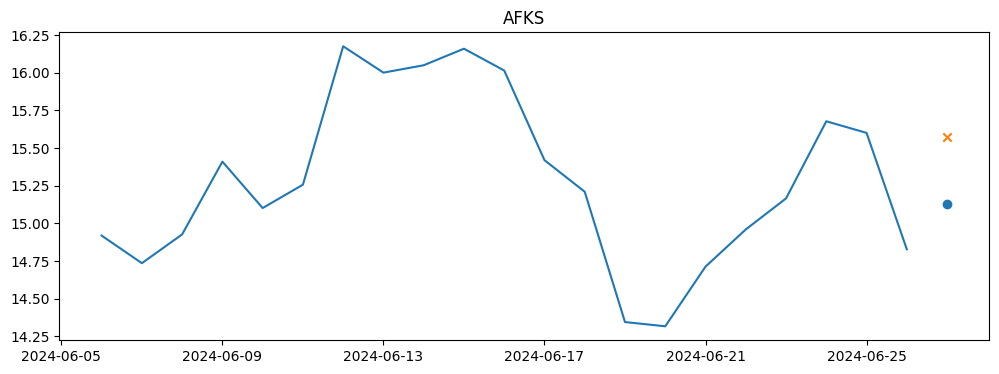

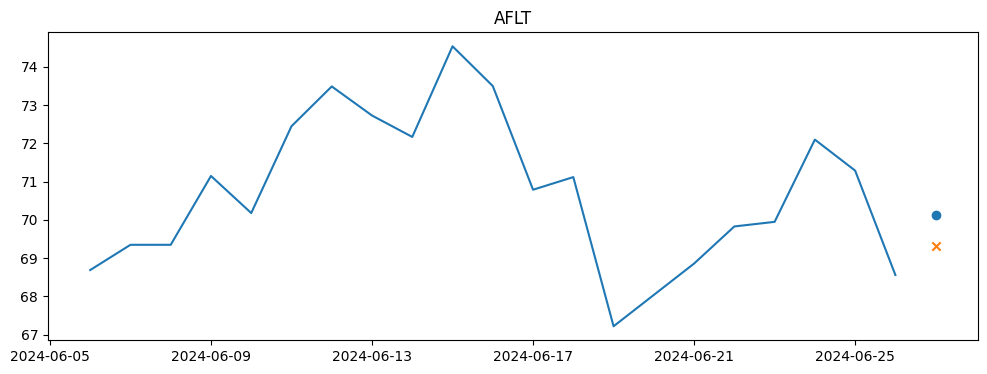

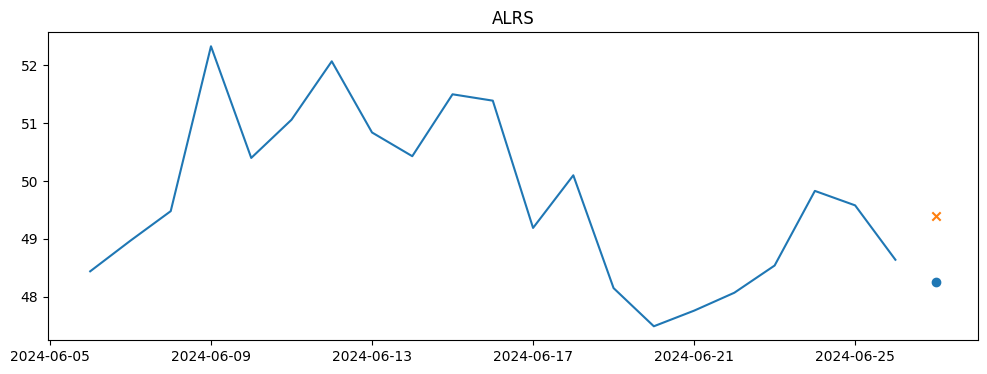

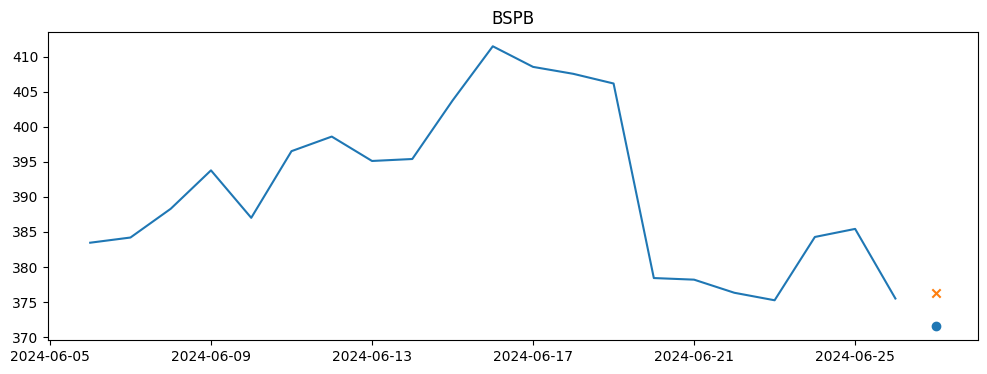

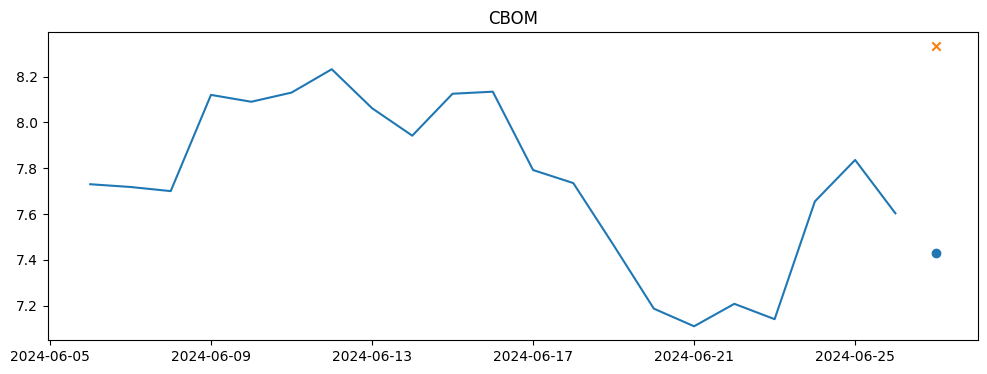

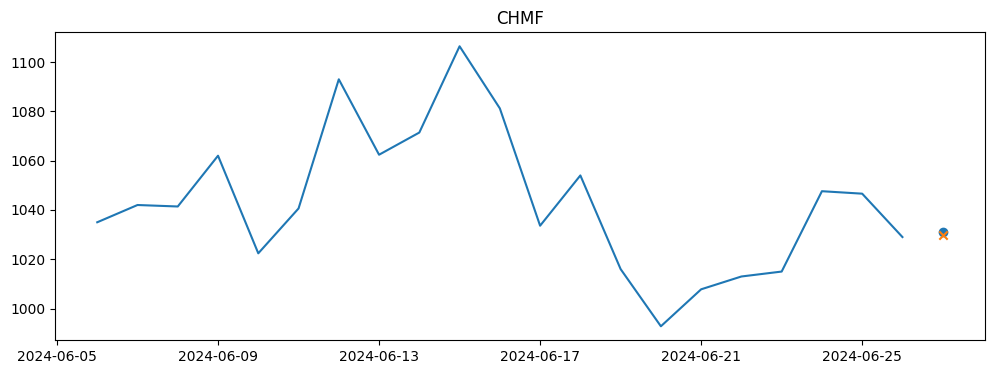

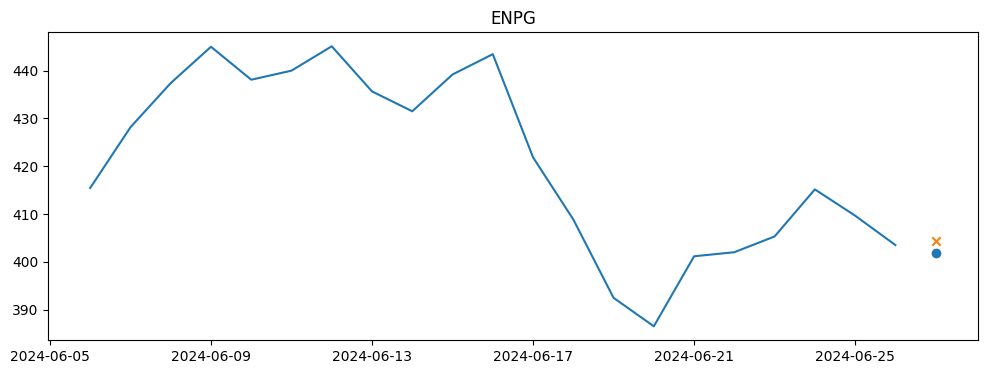

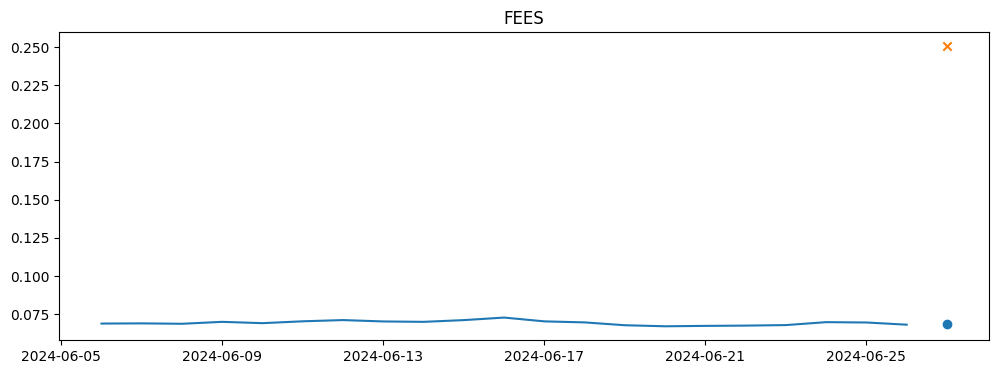

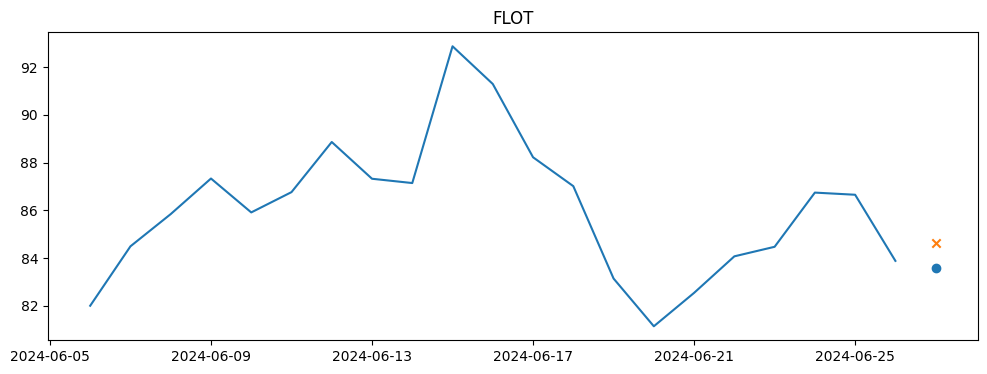

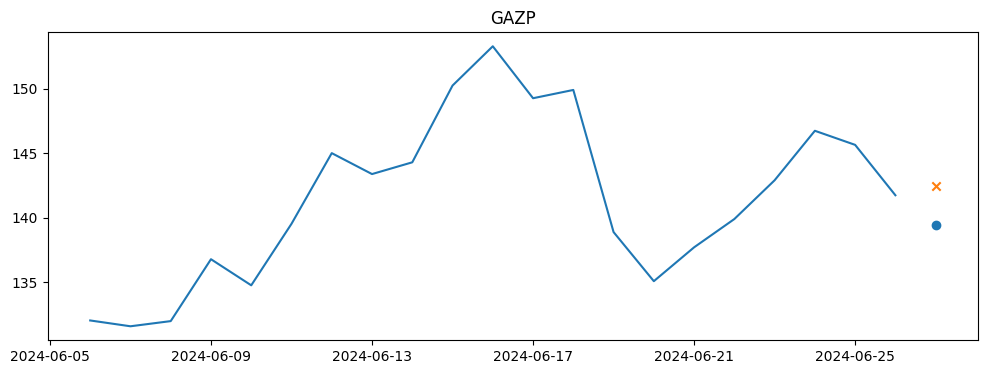

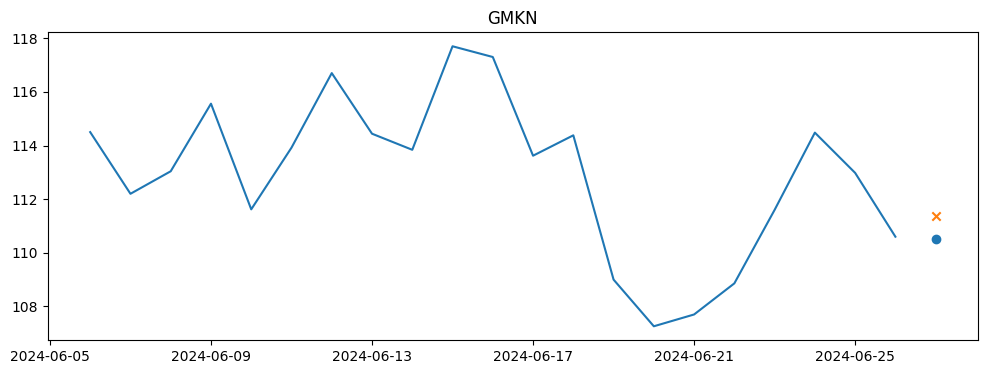

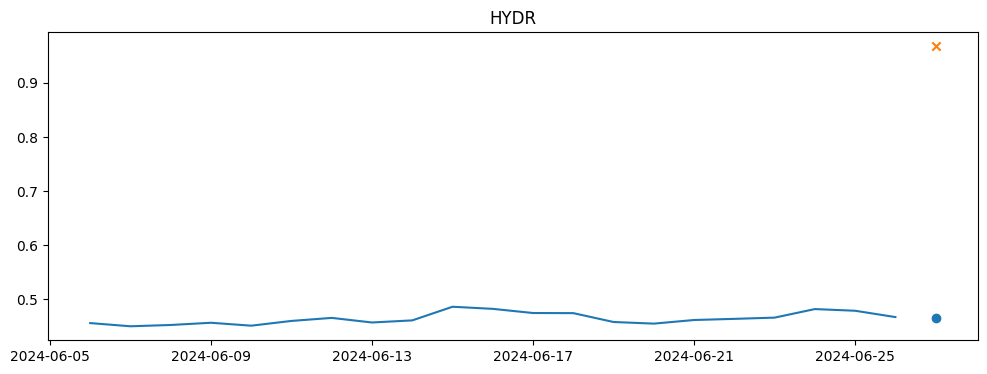

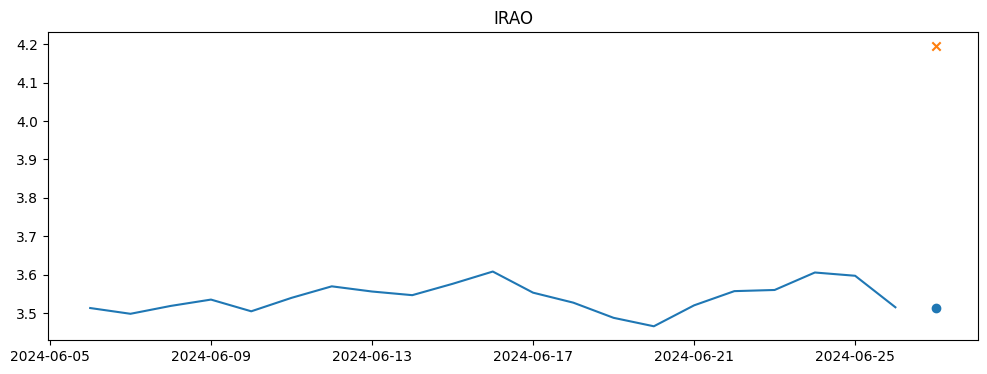

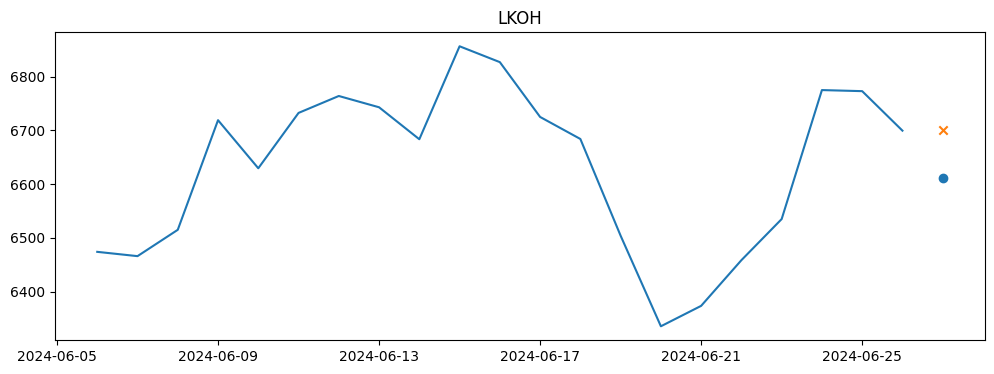

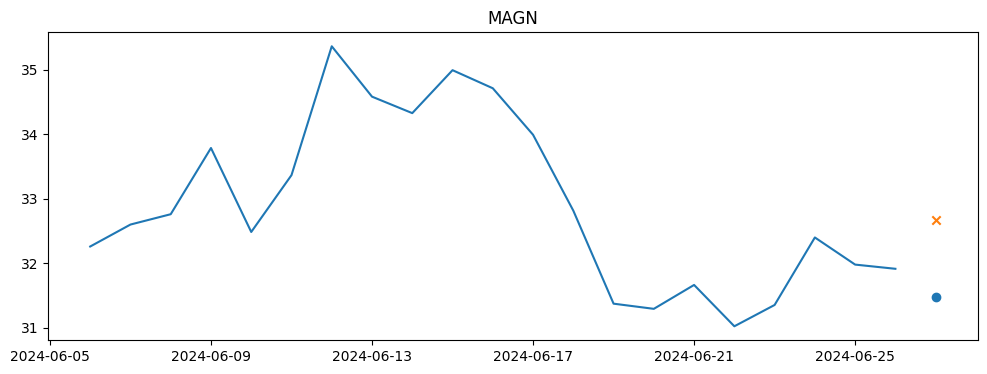

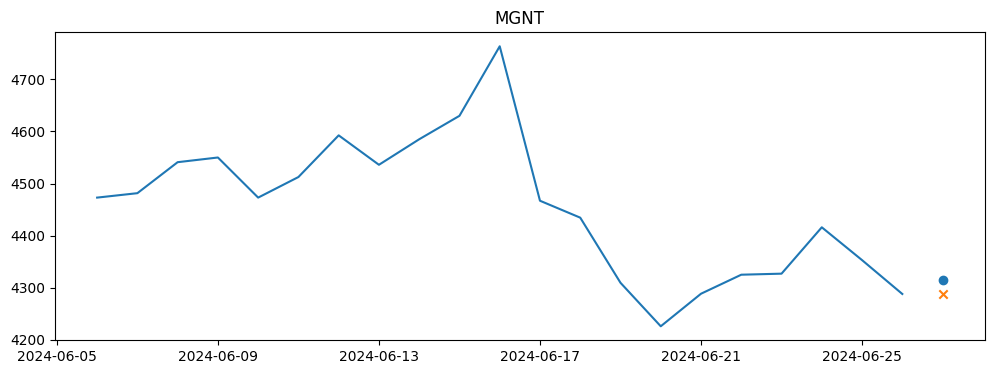

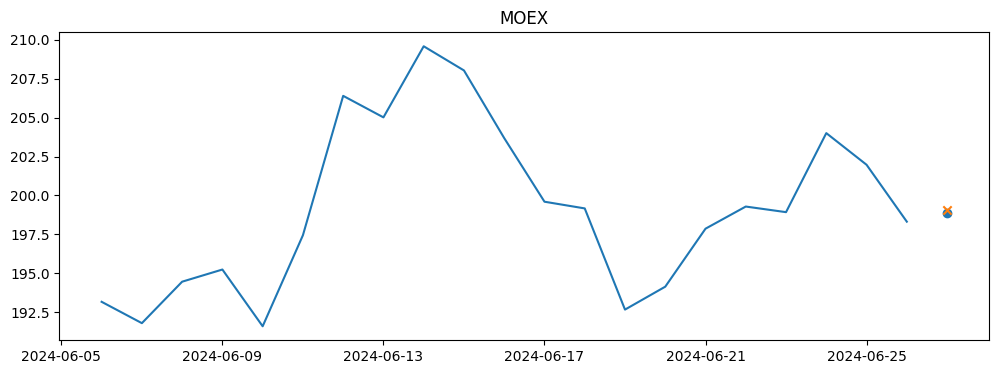

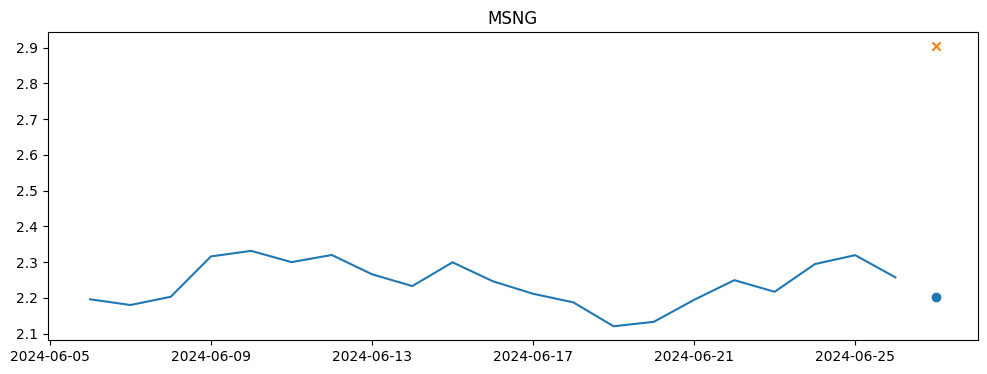

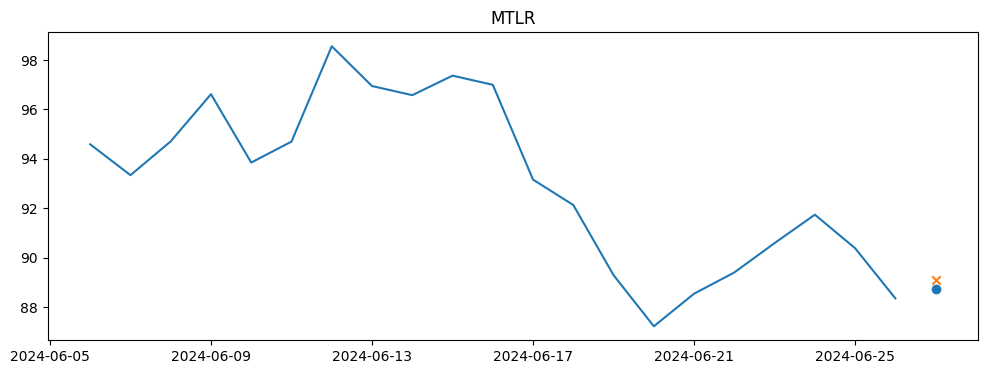

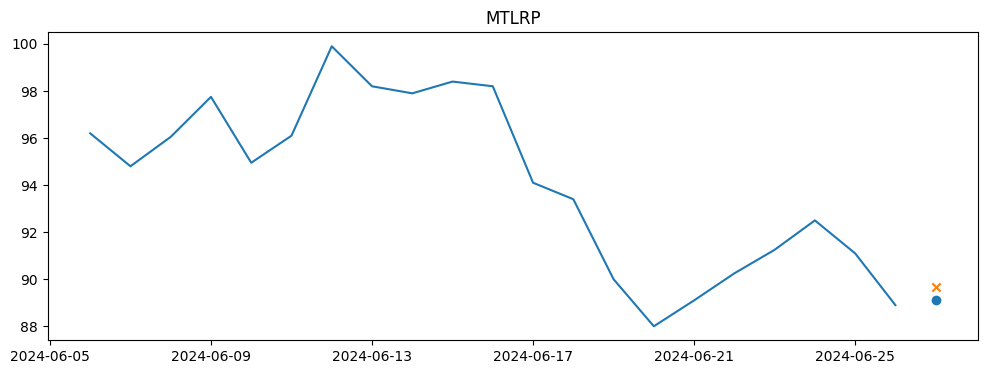

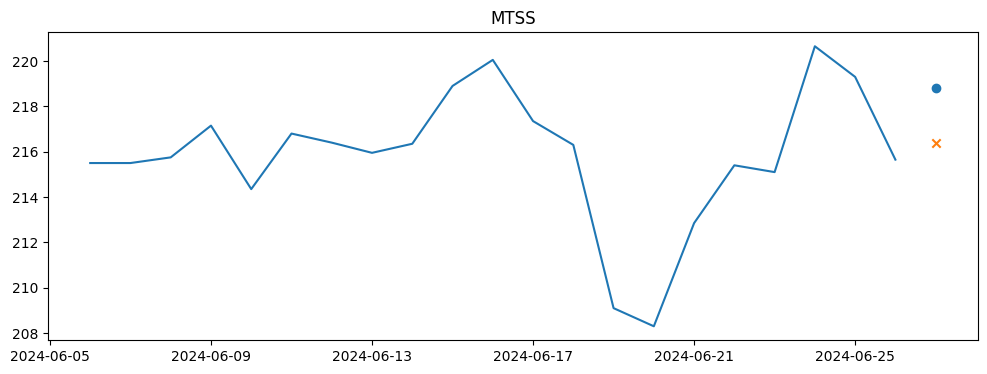

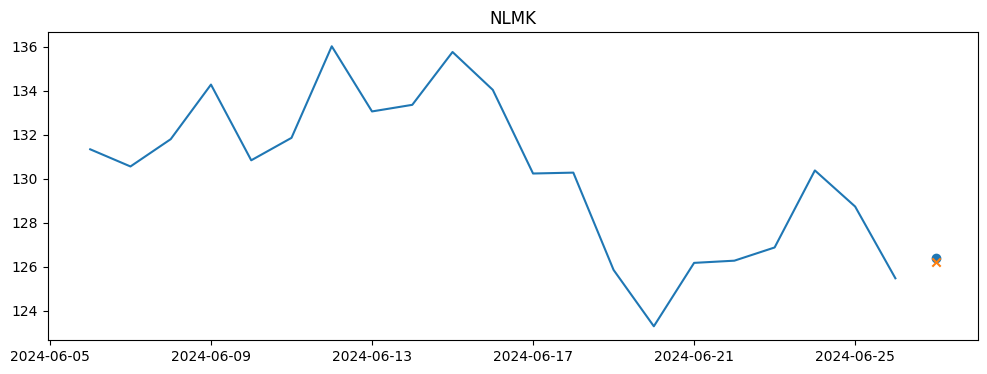

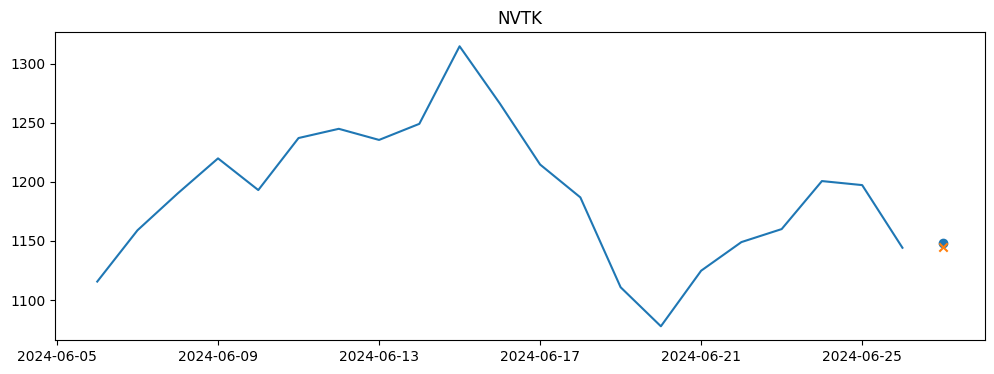

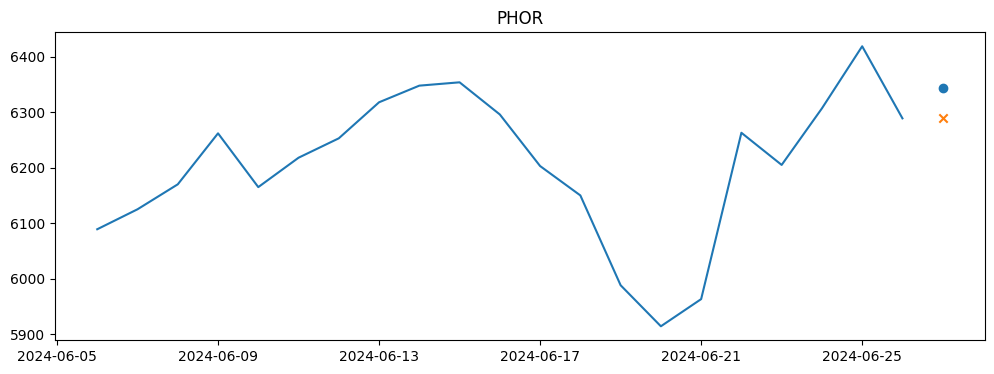

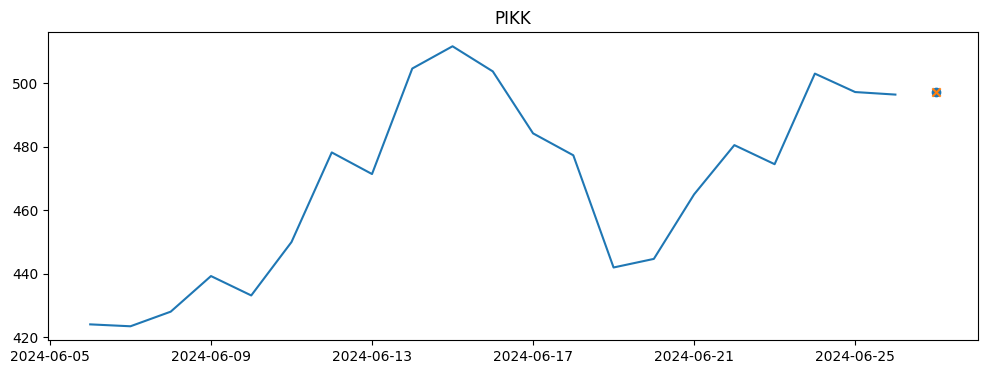

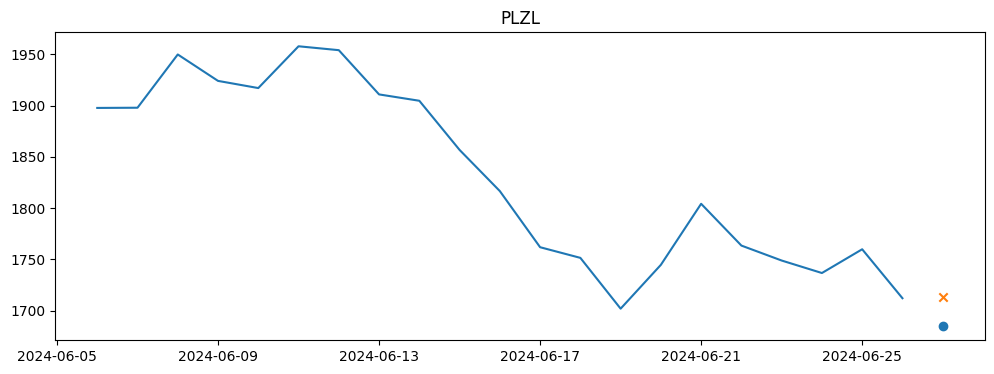

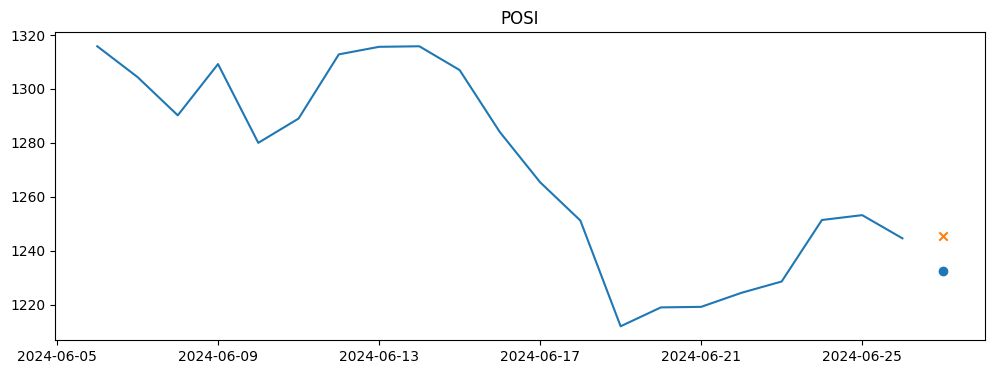

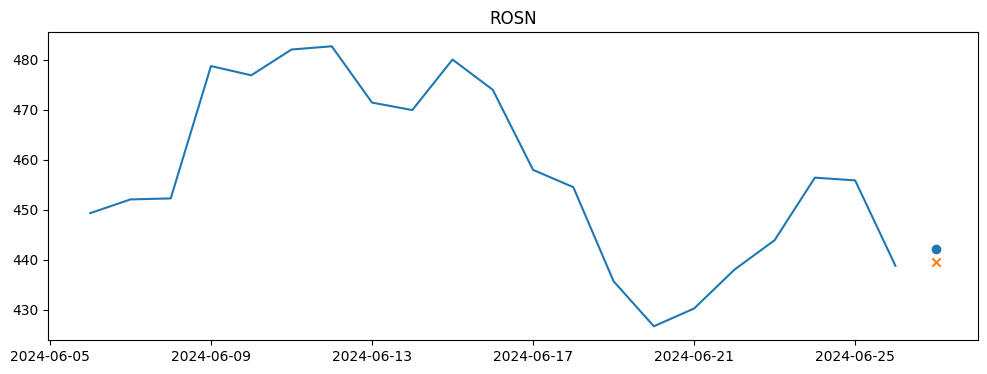

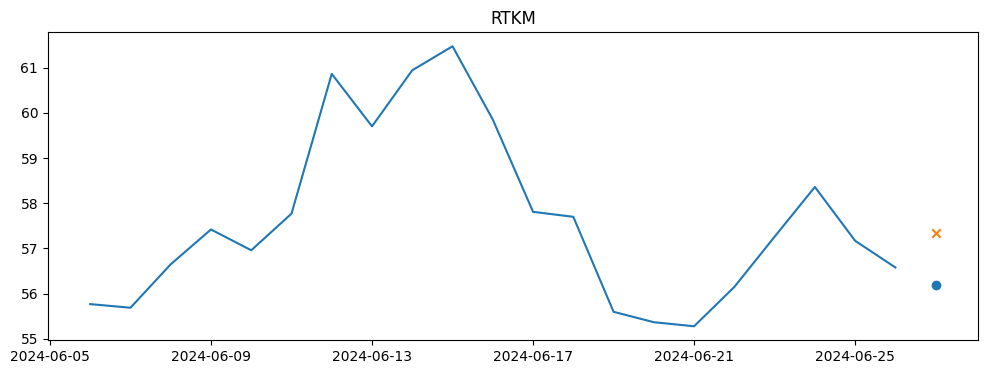

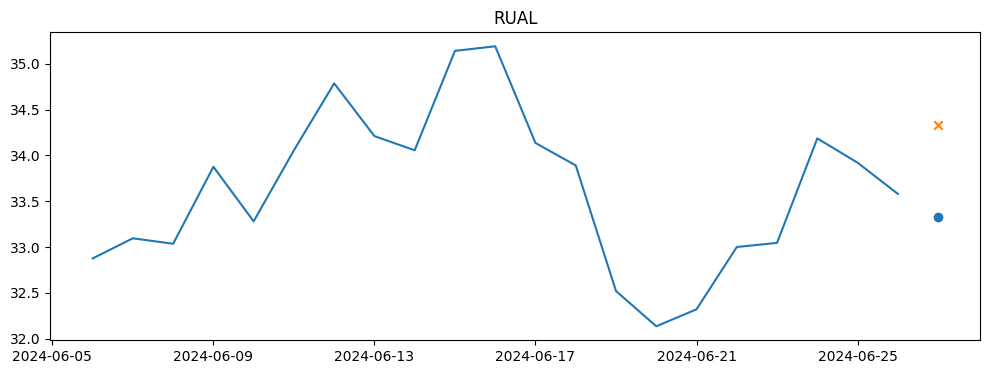

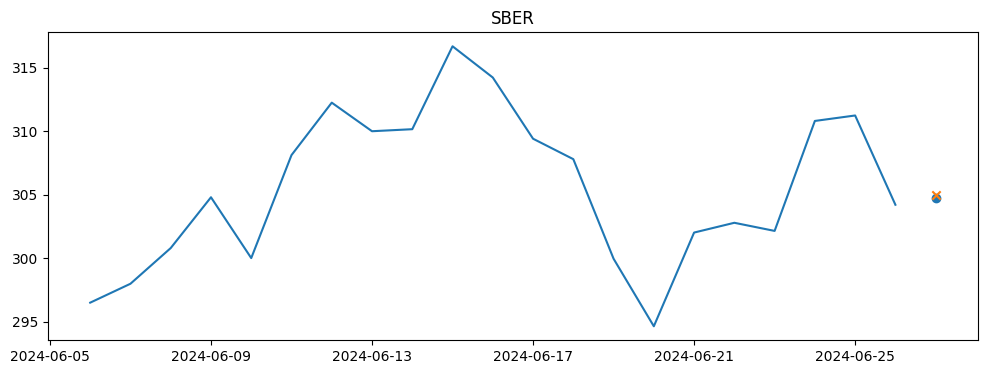

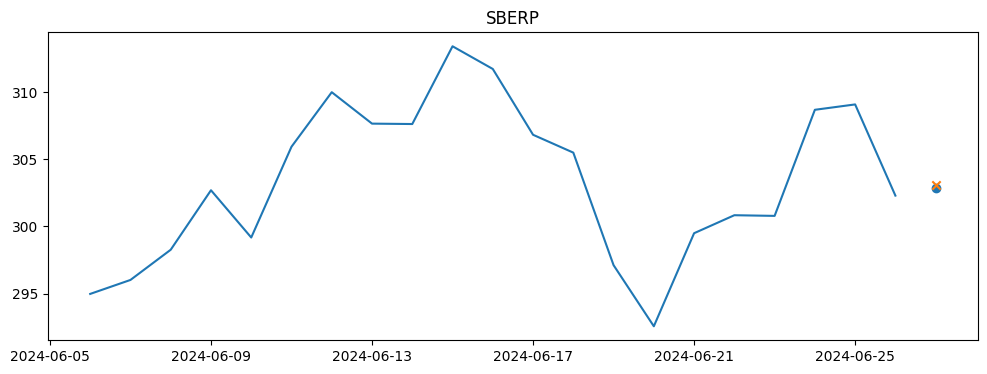

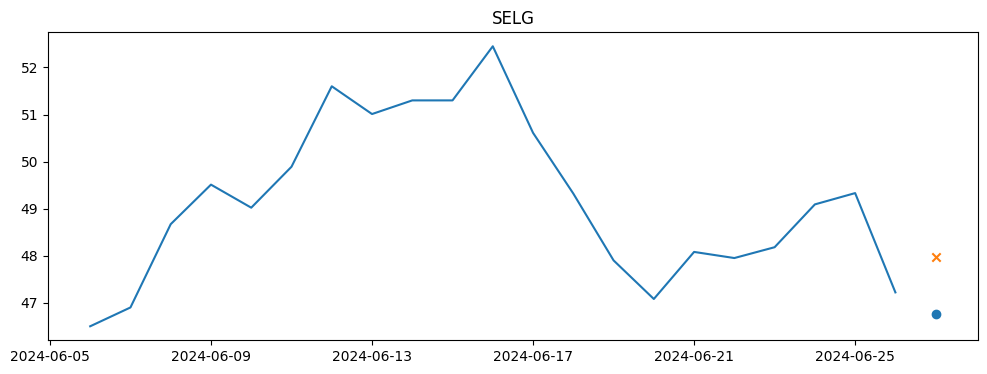

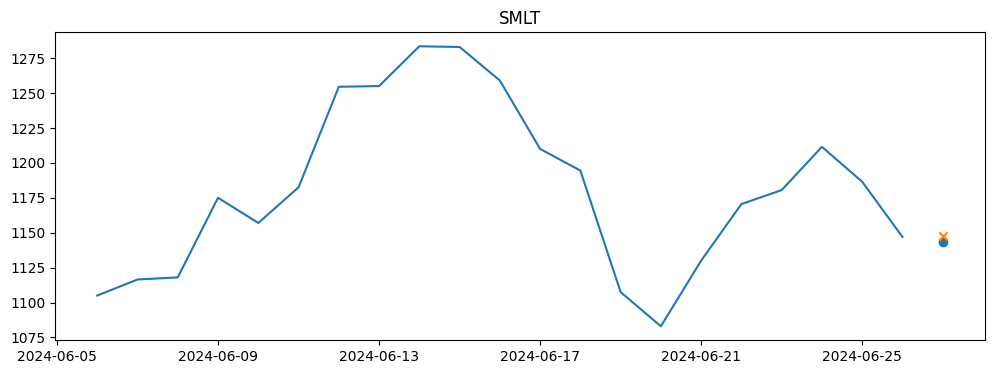

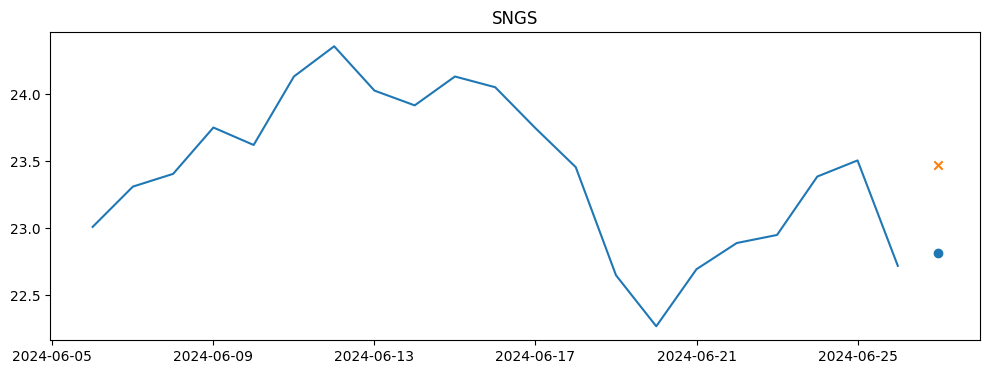

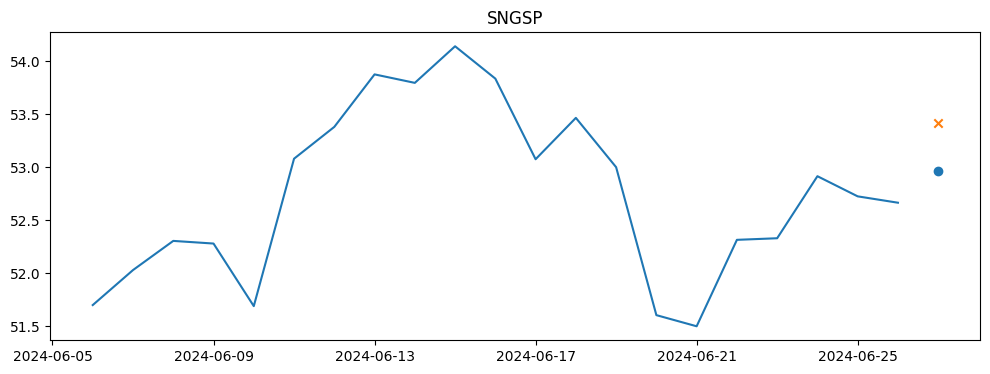

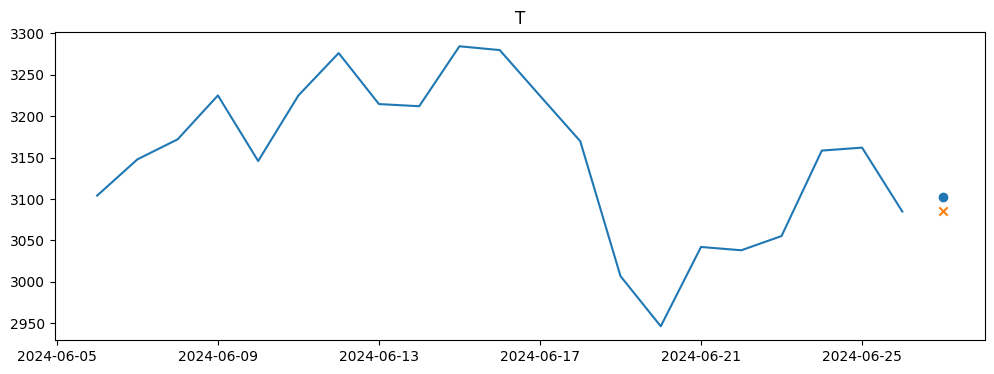

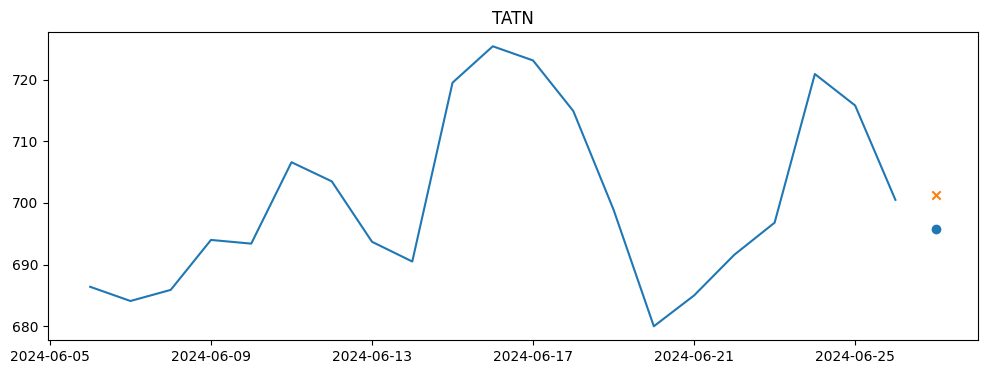

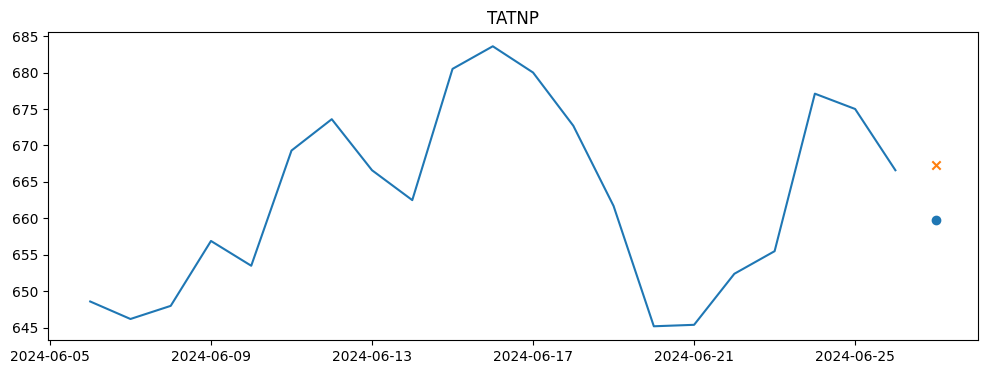

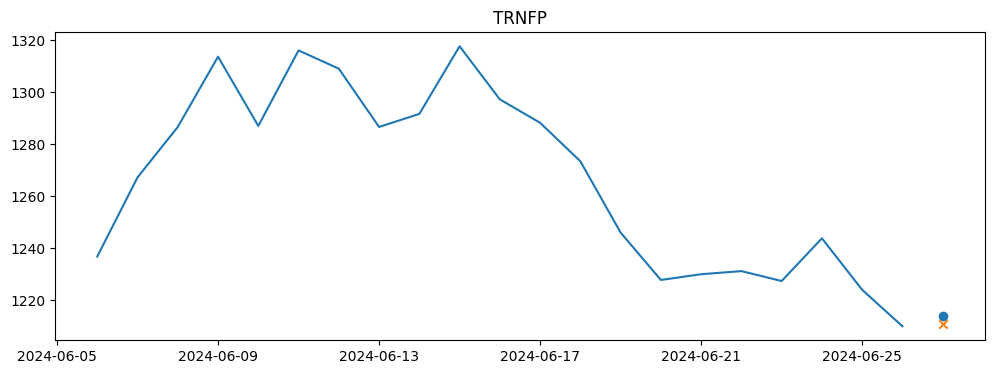

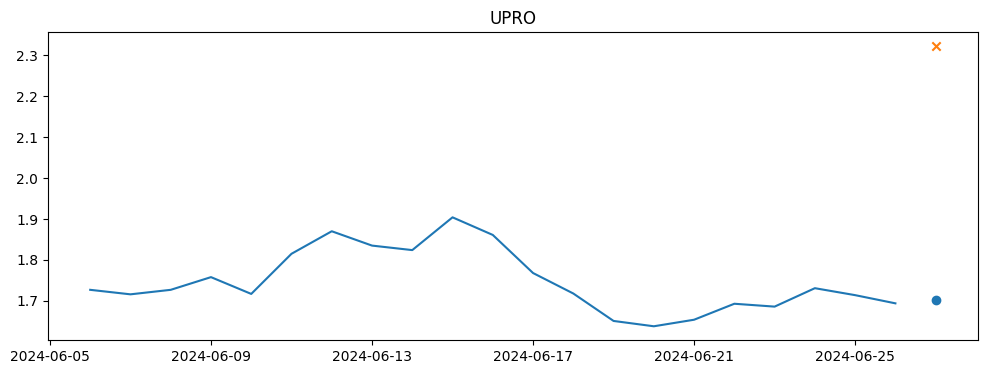

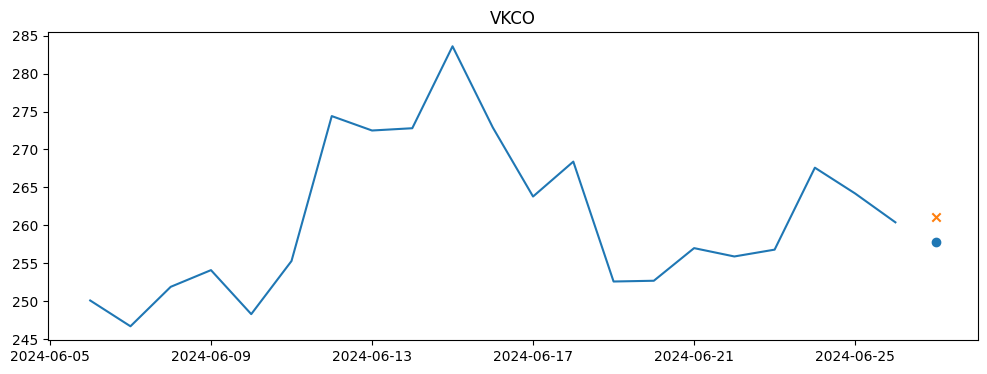

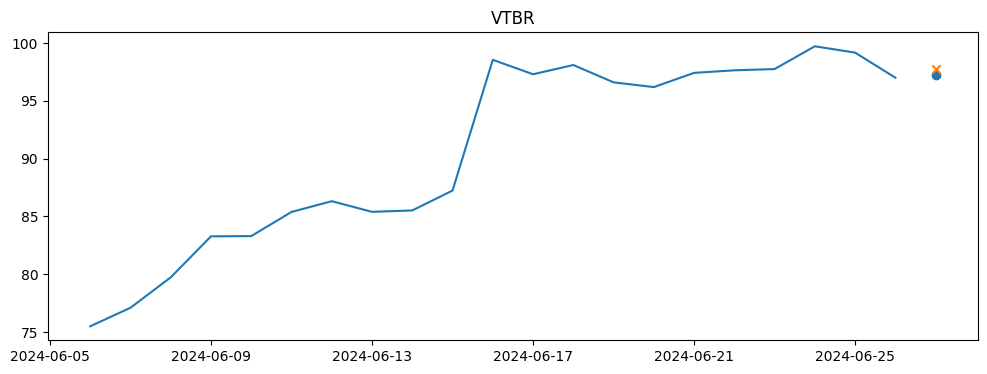

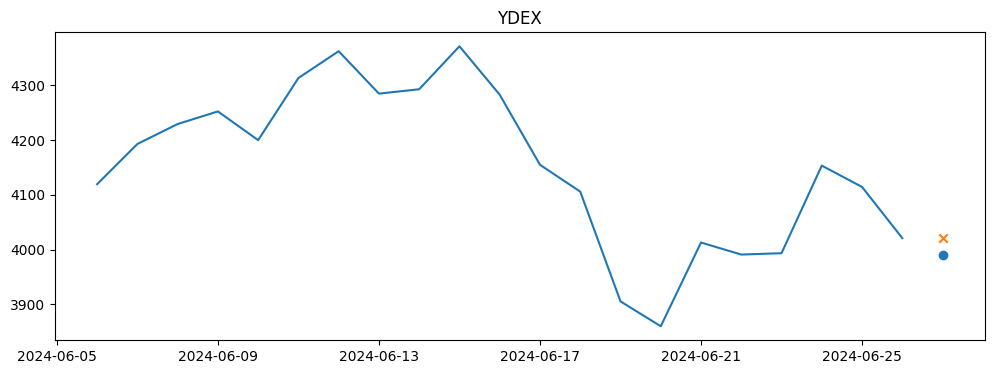

In [525]:
for ticker in df['SECID'].unique():
    plt.figure(figsize=(12, 4))
    plt.title(ticker)
    row_ticker = concatted_mlf[(concatted_mlf['unique_id'] == ticker) & (concatted_mlf['ds'] >= concatted_mlf['ds'].max() + pd.Timedelta(days=-20))]
    row_forecasts = forecasts[forecasts['unique_id'] == ticker]
    row_test = df[(df['TRADEDATE'] == df['TRADEDATE'].max()) & (df['SECID'] == ticker)]

    plt.plot(row_ticker['ds'], row_ticker['y'], label='train')
    plt.scatter(row_forecasts['ds'], row_test['CLOSE'], label='test')
    plt.scatter(row_forecasts['ds'], row_forecasts['TimesNet'], marker='x', label='forecast')